# Analyse des données - Partie 1

## environnement

### librairies

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.core.display import HTML
# from dataprep.eda import plot
from dataprep.eda import plot_correlation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import multidict as multidict
import re

In [12]:
# ceci est une reglagle permettant de voir l'intégralité des lignes et des colonnes des dataframes
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

### importation des données

In [13]:
data = pd.read_csv("./data/fr.openfoodfacts.org.products.csv", sep="\t", low_memory=False)
df = data

### Librairie de fonctions

Je vais stocker ici les fonctions que j'ai définies, afin de pouvoir les réutiliser par la suite

In [120]:
def get_missing_val_rates(df) -> pd.DataFrame : 
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                    'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True, ascending = False)
    return missing_value_df

def keep_only_french_products(df):
    countries = df["countries_fr"].unique().tolist()
    countries = ['missing' if x is np.nan else x for x in countries]
    fr_countries = [i for i in countries if "rance" in i]
    return df[df["countries_fr"].isin(fr_countries)]

def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - (1.5*IQR)
    lim_sup = Q3 + (1.5*IQR)
    return df[(df[column]<lim_inf) | (df[column]>lim_sup)]

def replace_outliers_with_nan(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - (1.5*IQR)
    lim_sup = Q3 + (1.5*IQR)
    df[column][df[column] < lim_inf] = None
    df[column][df[column] > lim_sup] = None

def limit_col(df, col, inf, sup):
    df[col][df[col]<inf] = None
    df[col][df[col]>sup] = None

def get_outoflimit(df, col, inf, sup):
    return df[(df[col]<inf) | (df[col]>sup)]
    
def clean_col(df, column):
    df_subset = df.loc[df[column].notna()]
    df_subset = rm_outliers(df_subset, column)
    return df_subset

def get_most_frequent(df, col, n)->list:
    return df[col].value_counts()[:n].index.tolist()

def num_stats(df, column):
    nb_unique = df[column].nunique()
    nb_missing = df[column].isna().sum()
    missing_percent = (nb_missing / len(df[column])) *100
    minimum = df[column].min()
    maximum = df[column].max()
    percentile_5 = df[column].quantile(.05)
    Q1 = df[column].quantile(.25)
    median = df[column].median()
    Q3 = df[column].quantile(.75)
    percentile_95 = df[column].quantile(.95)
    range = maximum - minimum
    IQR = Q3 - Q1
    mean = df[column].mean()
    std = df[column].std()
    variance = df[column].var()
    sum = df[column].sum()
    kurtosis = df[column].kurt()
    cv = (std/mean)*100
    df_return = pd.DataFrame({
        "nb_unique" : [nb_unique],
        "nb_manquants" : [nb_missing],
        "% manquant" : [missing_percent],
        "minimum" : [minimum],
        "quantile 5%" : [percentile_5],
        "Q1" : [Q1],
        "mediane" : [median],
        "Q3" : [Q3],
        "quantile 95%" : [percentile_95],
        "maximum" : [maximum],
        "amplitude" :  [range],
        "IQR" : [IQR],
        "moyenne" : [mean],
        "écart-type" : [std],
        "variance" : [variance],
        "somme" : [sum],
        "kurtosis" : [kurtosis],
        "coefficient de variation" : [cv]
    })
    return df_return

def cat_stats(df, column):
    nb_unique = df[column].nunique()
    nb_missing = df[column].isna().sum()
    missing_percent = (nb_missing / len(df[column])) *100
    most_frequent = df[column].value_counts().idxmax()
    most_frequent_rate = df[column].value_counts(normalize=True).tolist()[0]*100
    df_return = pd.DataFrame({
        "nb_unique" : [nb_unique],
        "nb_manquants" : [nb_missing],
        "% manquant" : [missing_percent],
        "valeur la plus fréquente" : [most_frequent],
        "% valeur la plus fréquente" : [most_frequent_rate]
    })
    return df_return

def stats(df, column):
    if(df[column].dtype=="object"):
        df_return = cat_stats(df, column)
    else:
        df_return = num_stats(df, column)
    return df_return

def bar_top(df, column, top):
    df_plot = df.copy()
    df_plot.dropna(subset=[column], inplace=True)
    ax = sns.countplot(y=df_plot[column], 
                       order=df_plot[column].value_counts().iloc[:top].index, 
                       palette='rocket')
    ax.tick_params(axis='y', length=0)
    fig = plt.gcf()
    fig.suptitle("Top {} des {} valeurs de {}".format(top, df_plot[column].nunique(), column))
    plt.tight_layout()
    fig.set_size_inches(10,10)
    plt.show()
    return

def wc(df, col, sep=" "):
    mask = np.array(Image.open('./apple.jpg'))
    pattern = re.compile('[\W_]+')
    words = []
    for string in df[col]:
        string = pattern.sub('', str(string)) # enlève tous les caractères que l'on ne veut pas
        ls_words= str(string).split(sep)
        for w in ls_words:
            if (w!=' ')and (w!='nan'):
                words.append(w)
    cnt=Counter(words)
    wordcloud = WordCloud(width=1080, height=920, mask=mask).fit_words(cnt)
    plt.figure(figsize=(25,15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.show()
    return

def most_common_word(labels, sep=","):
    words=[]
    for lab in labels:
        words+=str(lab).split(sep)
    count=Counter(words)
    for word in count.most_common(100):
        print(word)

def fillrate_pie(df):
    l=4
    i=0
    j=0
    str_missing = "nombre de valeurs manquantes"
    str_nb_val = "nombre de valeurs"
    str_fill_rate = "taux de remplissage"
    str_real_val = "valeurs fournies"
    t=pd.DataFrame(index=[str_missing, 
                          str_nb_val,
                          str_fill_rate], 
                   columns=df.columns )
    for col in df.columns:
        nb_nan=df[col].isnull().sum()
        t.loc[str_missing,col]=nb_nan              
        t.loc[str_nb_val, col]= df.shape[0]-nb_nan 
        t.loc[str_fill_rate, col]=(df.shape[0]-nb_nan)/(df.shape[0]*1.0)

    f, ax = plt.subplots((df.shape[1]//5)+1, 
                         5, 
                         figsize=(l*5, l*(df.shape[1]//5)))
    f.subplots_adjust(left=0, 
                      right=0.9, 
                      top= 0.95, 
                      bottom= 0., 
                      wspace=0.9, 
                      hspace=0.9)
    f.tight_layout(rect=(0, 0, 0.95,0.95 ),
                   h_pad=0.5, 
                   w_pad=0.5)
    for col in df.columns:
        if i < 5:
            ax[j,i].pie(t.loc[[str_missing, str_nb_val], col], 
                            autopct='%0.1f',
                       colors=["red", "green"])
            ax[j,i].set_title(col)
            i+=1
        else:
            i=0
            j+=1
            ax[j,i].pie(t.loc[[str_missing, str_nb_val], col], 
                            autopct='%0.1f',
                       colors=["red", "green"])
            ax[j,i].set_title(col)
            i+=1
    f.legend(labels=[str_missing, 
                     str_real_val], 
             fontsize=15) 
    f.suptitle("ratio : {} / {}".format(str_real_val, 
                                                    str_missing), 
               fontsize=40, 
               fontweight=30)
    return

def pie_many_cols(df, cols, dimensions):
    ylabel = ""
    title = "Répartition des produits par "
    fontsize = 14
    nb_rows = int(len(cols)/2) + 1
    i = 1
    for col in cols:
        values_name = df[col].value_counts().index
        df_sum = df[col].value_counts()
        j = 0
        for value in values_name:
            if j >= 30:
                break
            elif df_sum[value]/df_sum.sum()*100 >= 1.5:
                j += 1
            else:
                break

        df_tmp = df[col].where(df[col].isna() 
                               | df[col].isin(df[col].value_counts().index[:j]), 
                               other='autres')

        if 'autres' not in df_tmp.value_counts().index:
            plt.subplot(nb_rows, 2, i)
            df_tmp.value_counts().plot.pie(figsize=dimensions,
                                           textprops={'fontsize': fontsize},
                                           autopct='%1.1f%%',
                                           pctdistance = 0.85)
            plt.ylabel(ylabel)
            title += col
            plt.title(title, pad=50)
            i += 1
        elif df_tmp.value_counts()['autres']/df_tmp.value_counts().sum()*100 < 60:
            plt.subplot(nb_rows, 2, i)
            df_tmp.value_counts().plot.pie(figsize=dimensions,
                                           textprops={'fontsize': fontsize},
                                           autopct='%1.1f%%',
                                           pctdistance = 0.85)
            plt.ylabel(ylabel)
            title += col
            plt.title(title, pad=50)
            i += 1
    plt.show()
    return

def scatter_one_to_many(df, ycol, xcols_list, title):
    ds=df.copy()
    x=pd.DataFrame(ds[ycol], 
                   columns=[ycol])
    fig=plt.figure(figsize=(30,15))
    plt.style.use("ggplot")
    plt.title(title)
    for col in xcols_list:
        plt.plot(ds[col], x, 'o',label=col)
    plt.ylabel(ycol)
    plt.plot([0, 100], [0, 3765.6], linewidth=5, linestyle='-', color='pink')# 9 Kcal = 37.656 kJ
    plt.plot([0, 100], [0, 1673.6], linewidth=7, color= 'blue', linestyle='-')# 4 Kcal = 1973.6 kJ
    plt.legend(loc='upper left', prop={'size':32})
    ax = plt.gca()
    # ax.set_xlim([0, 100])
    # ax.set_ylim([0, 0.03])
    return

def hist_distrib(df, column):
    df_plot = df.copy()
    df_plot.dropna(subset=[column], inplace=True)
    ax = sns.distplot(df_plot, 
                      x=df_plot[column])
    # ax.tick_params(axis='y', length=0)
    fig = plt.gcf()
    fig.suptitle("Distribution de {}".format(column))
    plt.tight_layout()
    fig.set_size_inches(10,10)
    plt.show()
    return

def plot(df, col):
    display(stats(df, col))
    if(df[col].dtype=="object"):
        bar_top(df, col, 10)
        wc(df, col)
    else:
        hist_distrib(df, col)
    return

## informations globales sur les données

### premier apperçu

In [15]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ]

### dimensions

In [16]:
print("Ce jeu de données contient {} colonnes et {} lignes".format(df.shape[0], df.shape[1]))

Ce jeu de données contient 320772 colonnes et 162 lignes


### Types de variables

<AxesSubplot:title={'center':'Type de données'}, ylabel='None'>

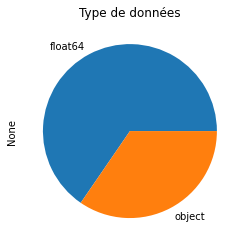

In [17]:
df.dtypes.value_counts().plot(kind="pie", title="Type de données")

In [18]:
df.dtypes

code                                           object
url                                            object
creator                                        object
created_t                                      object
created_datetime                               object
last_modified_t                                object
last_modified_datetime                         object
product_name                                   object
generic_name                                   object
quantity                                       object
packaging                                      object
packaging_tags                                 object
brands                                         object
brands_tags                                    object
categories                                     object
categories_tags                                object
categories_fr                                  object
origins                                        object
origins_tags                

Nous avons donc deux grands types de variables dans ce jeu de données :
- des variables qualitatives, ici avec le type ```object```
- des variables quantitatives, ici avec le type ```float64```

On peut séparer ces deux types de variables de la manière suivante :

#### Variables qualitatives

In [19]:
df.select_dtypes(include=['object']).columns.tolist()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'states',
 'states_tags',
 'states_fr',
 'main_category',
 'main_category_fr',
 'image_url',
 'image_small_url']

#### Variables quantitatives

In [20]:
df.select_dtypes(include=['float64']).columns.tolist()

['no_nutriments',
 'additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'nutrition_grade_uk',
 'energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'butyric-acid_100g',
 'caproic-acid_100g',
 'caprylic-acid_100g',
 'capric-acid_100g',
 'lauric-acid_100g',
 'myristic-acid_100g',
 'palmitic-acid_100g',
 'stearic-acid_100g',
 'arachidic-acid_100g',
 'behenic-acid_100g',
 'lignoceric-acid_100g',
 'cerotic-acid_100g',
 'montanic-acid_100g',
 'melissic-acid_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'alpha-linolenic-acid_100g',
 'eicosapentaenoic-acid_100g',
 'docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 'linoleic-acid_100g',
 'arachidonic-acid_100g',
 'gamma-linolenic-acid_100g',
 'dihomo-gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 'oleic-acid_100g',
 'elaidic-acid_100g',
 'gondoic-acid_100g',
 'mead-aci

### Classification des colonnes

Du point de vue des informations qu'elles contiennent, les variables peuvent être regroupées en 5 groupes :
- metadonnées
- informations logistiques (origines et dénomination)
- informations nutritionnelles qualitatives
- informations nutritionnelles quantitatives
- informations additionnelles

Regardons-les plus en détail, afin de décider quelles colonnes nous allons garder.

Les colonnes que nous allons garder seront contenues dans la liste suivante :

In [21]:
ls_keep = []

#### Métadonnées

Les métadonnées sont des informations sur la création et la modification de chaque produit (c'est à dire chaque ligne de notre jeu de données). Elles n'ont à priori que très peu d'intérêt pour nous, et elles seront donc éliminées.
Voici une liste de ces colonnes :

In [22]:
ls_metadata = [
    "code",
    "url",
    "creator",
    "created_t",
    "created_datetime",
    "last_modified_t",
    "last_modified_datetime"
]

#### Informations logistiques

Elles contiennent des informations sur l'origine et la dénomination des produits. Pour savoir lesquelles nous allons conserver, créons une première liste de ces colonnes, puis regardons un échantillon du dataframe :

In [23]:
ls_logistic = [
    "product_name",
    "generic_name",
    "quantity",
    "packaging",
    "packaging_tags",
    "brands",
    "brands_tags",
    "categories",
    "categories_tags",
    "categories_fr",
    "origins",
    "origins_tags",
    "manufacturing_places", 
    "manufacturing_places_tags", 
    "labels", 
    "labels_tags",
    "labels_fr", 
    "emb_codes", 
    "emb_codes_tags", 
    "first_packaging_code_geo",
    "cities", 
    "cities_tags", 
    "purchase_places", 
    "stores", 
    "countries",
    "countries_tags", 
    "countries_fr", 
    "pnns_groups_1", 
    "pnns_groups_2",
    "main_category", 
    "main_category_fr"
]

In [24]:
df[ls_logistic].sample(10)

,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,pnns_groups_1,pnns_groups_2,main_category,main_category_fr
149477,100% Extra Virgin Olive Oil,NaN,NaN,NaN,NaN,Casa Cardenas,casa-cardenas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,NaN,NaN,NaN,NaN
253769,Confiture Artisanale Fraise,NaN,NaN,NaN,NaN,Les Confitures De La Creation,les-confitures-de-la-creation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN
119807,Parmesan,NaN,NaN,NaN,NaN,Sartori Company,sartori-company,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,NaN,NaN,NaN,NaN
10028,Dark Chocolate,NaN,NaN,NaN,NaN,"Dreamhouse Fine Foods, Rite Aid Corporation","dreamhouse-fine-foods,rite-aid-corporation",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,NaN,NaN,NaN,NaN
67068,"Stars & Stripes, Root Beer",NaN,NaN,NaN,NaN,Cott Beverage Inc.,cott-beverage-inc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,NaN,NaN,NaN,NaN
297046,Exotic Island,NaN,NaN,NaN,NaN,SARASAY,sarasay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Suisse,en:switzerland,Suisse,NaN,NaN,NaN,NaN
95698,"Sunder's, Organic Mini Pretzels",NaN,NaN,NaN,NaN,Snyder's-Lance Inc.,snyder-s-lance-inc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,NaN,NaN,NaN,NaN
198423,Saucisson à l'ail,NaN,250 g,"Plastique,Sous-Vide","plastique,sous-vide",Stoeffler,stoeffler,"Viandes,Charcuteries,Saucissons,Saucissons à l...","en:meats,en:prepared-meats,fr:saucissons,fr:sa...","Viandes,Charcuteries,Saucissons,Saucissons à l...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,FR 67.348.002 EC,fr-67-348-002-ec,"48.466667,7.483333",NaN,obernai-bas-rhin-france,Langon,Leclerc,France,en:france,France,Fish Meat Eggs,Processed meat,fr:saucissons,Saucissons
162085,"Oraganic Gemini, Tigernut Raw Snack, Original",NaN,NaN,NaN,NaN,Organic Gemini,organic-gemini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,NaN,NaN,NaN,NaN
12446,Premium Creamery Select Ice Cream,NaN,NaN,NaN,NaN,Western Family,western-family,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,NaN,NaN,NaN,NaN


Les colonnes que nous conserverons ici sont :
- ```product_name``` : le nom du produit
- ```brands``` : le nom de la marque du produit
- ```countries_fr```  : le nom du pays où le produit est vendu (peut nous permettre par exemple de filtrer uniquement les produits vendus en france)
- ```pnns_groups_1``` : le type de produits. Sera utile pour calculer les nutriscores manquants, car son calcul est différent selon si le produit est liquide (beverage) ou solide

In [25]:
ls_logistic_keep = [
    "product_name",
    "brands",
    "countries_fr",
    "pnns_groups_1"
]

Ajoutons ces colonnes à la liste des colonnes à conserver

In [26]:
ls_keep += ls_logistic_keep

#### Informations nutritionnelles qualitatives

Les informations nutritionnelles sont les informations généralement recherchées par les consommateurs. Nous conserverons les plus pertinentes

In [27]:
ls_nutri_quali= [
    "ingredients_text", 
    "allergens",
    "allergens_fr", 
    "traces", 
    "traces_tags", 
    "traces_fr", 
    "serving_size",
    "no_nutriments", 
    "additives_n", 
    "additives", 
    "additives_tags", 
    "additives_fr",
    "ingredients_from_palm_oil_n", 
    "ingredients_from_palm_oil",
    "ingredients_from_palm_oil_tags",
    "ingredients_that_may_be_from_palm_oil_n",
    "ingredients_that_may_be_from_palm_oil",
    "ingredients_that_may_be_from_palm_oil_tags", 
    "nutrition_grade_uk",
    "nutrition_grade_fr"
]

Regardons un échantillon de ce que contiennent ces colonnes :

In [28]:
df[ls_nutri_quali].sample(10)

,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr
13628,"Beef, water, salt, contains 2% or less of corn...",NaN,NaN,NaN,NaN,NaN,26 g (1 STICK),NaN,5.0,[ beef -> en:beef ] [ water -> en:water ] ...,"en:e316,en:e250,en:e320,en:e321,en:e330","E316 - Erythorbate de sodium,E250 - Nitrite de...",0.0,NaN,NaN,0.0,NaN,NaN,NaN,e
98270,"Whole grain rolled oats, sugar, salt, oat flou...",NaN,NaN,NaN,NaN,NaN,43 g (43 g),NaN,4.0,[ whole-grain-rolled-oats -> en:whole-grain-r...,"en:e170,en:e412,en:e150a,en:e101","E170 - Carbonate de calcium,E412 - Gomme de gu...",0.0,NaN,NaN,0.0,NaN,NaN,NaN,d
97929,"Turkey breast, turkey broth, salt, less than 2...",NaN,NaN,NaN,NaN,NaN,"51 g (4 SLICES, 16OZ. PACKAGE)",NaN,6.0,[ turkey-breast -> en:turkey-breast ] [ bre...,"en:e325,en:e339iii,en:e407,en:e262ii,en:e316,e...","E325 - Lactate de sodium,E339iii - Phosphate d...",0.0,NaN,NaN,0.0,NaN,NaN,NaN,d
3994,"Coffee (water, coffee extract), milk, sugar, c...",NaN,NaN,NaN,NaN,NaN,240 ml (1 cup),NaN,4.0,[ coffee -> en:coffee ] [ water -> en:water...,"en:e407,en:e418,en:e331,en:e150a","E407 - Carraghénanes,E418 - Gomme gellane,E331...",0.0,NaN,NaN,0.0,NaN,NaN,NaN,b
159293,"Harvest blend trail mix - dried currants, drie...",NaN,NaN,NaN,NaN,NaN,105 g (1 PACKAGE),NaN,1.0,[ harvest-blend-trail-mix -> en:harvest-blend...,en:e322,E322 - Lécithines,0.0,NaN,NaN,0.0,NaN,NaN,NaN,d
236497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a
35376,"Sugar, corn syrup, water, citric acid, artific...",NaN,NaN,NaN,NaN,NaN,5 g (1 POPS),NaN,3.0,[ sugar -> en:sugar ] [ corn-syrup -> en:co...,"en:e330,en:e171,en:e129","E330 - Acide citrique,E171 - Oxyde de titane,E...",0.0,NaN,NaN,0.0,NaN,NaN,NaN,d
181177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293396,"FARINE DE BLÉ, eau, huile d'olive 6%, éthanol,...",BLÉ,NaN,NaN,NaN,NaN,100 g,NaN,1.0,[ farine-de-ble -> fr:farine-de-ble ] [ far...,en:e1510,E1510 - Éthanol,0.0,NaN,NaN,0.0,NaN,NaN,NaN,b
248526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d


Nous conserverons les colonnes suivantes :
- ```ingredient_text``` : composition du produit
- ```allergens``` : liste des composants succeptibles de provoquer des allergies
- ```traces``` : traces de composants allergènes
- ```additives``` : liste des additifs utilisés
- ```ingredients_from_palm_oil_n``` : permet de savoir si le produit contient de l'huile de palme ou non
- ```nutrition_grade_fr``` : score nutritionnel français, de A à E

In [29]:
ls_nutri_quali_keep = [
    "ingredients_text",
    "allergens",
    "traces",
    "additives",
    "ingredients_from_palm_oil_n",
    "nutrition_grade_fr"
]

In [30]:
df[ls_nutri_quali_keep].dropna().sample(10)

,ingredients_text,allergens,traces,additives,ingredients_from_palm_oil_n,nutrition_grade_fr
274129,100% _Almonds_ (whole skin on).,Almonds,"Fruits à coque,Arachides,Graines de sésame",[ 100-almonds -> en:100-almonds ] [ almonds...,0.0,c
269586,"Crème glacée (51 %) nappée de caramel (16 %), ...","Lait, lait, lait, lait, orge, lait, lactose, l...","Fruits à coque,Arachides",[ creme-glacee -> fr:creme-glacee ] [ creme...,1.0,d
223520,"_crème_ fraîche (75% de la crème fouettée, 18%...","crème, lait, œuf, œuf, lactose, lait","Gluten,Fruits à coque,Soja",[ creme-fraiche -> fr:creme-fraiche ] [ cre...,0.0,c
232909,"Pâte 50 % : farine de _blé_, eau, fécule de po...","blé, blé, blé, soja, lait, fromage, fromage","Eggs,Sesame seeds",[ pate-50 -> fr:pate-50 ] [ pate -> fr:pate...,0.0,c
181186,"49% flocons d'_avoine_ complète, 21% flocons d...","avoine, épeautre, noisettes, amandes","Lait,Fruits à coque,Arachides,Graines de sésam...",[ 49-flocons-d-avoine-complete -> fr:49-floco...,0.0,a
244742,"sucre, beurre de cacao, _lait_ en poudre, fram...","lait, soja","Œufs,Fruits à coque,Graines de sésame",[ sucre -> fr:sucre ] [ beurre-de-cacao -> ...,0.0,e
207294,"Fromage au _lait_ pasteurisé, protéines de _la...","lait, lait","Gluten,Lait de chèvre",[ fromage-au-lait-pasteurise -> fr:fromage-au...,0.0,d
227088,"Riz basmati cuit 58% (riz, eau) - oignons 9,1%...",œuf,"Céleri,Crustacés,Poisson,Lait,Mollusques,Mouta...",[ riz-basmati-cuit-58 -> fr:riz-basmati-cuit-...,0.0,c
231839,Farine de _blé*_ type 80 moulu à la meule de p...,"blé*, blé","gluten,oeufs,soja,dérivés de lait,fruits à coq...",[ farine-de-ble-type-80-moulu-a-la-meule-de-p...,0.0,a
236267,Pâtes cuisinées &quot;Al Dente&quot; (53 %) : ...,"blé, crème","Céleri,Crustacés,Œufs,Poisson,Gluten,Lait,Moll...",[ pates-cuisinees-quot -> fr:pates-cuisinees-...,0.0,c


In [31]:
ls_keep += ls_nutri_quali_keep

#### informations nutritionnelles quantitatives

À l'instar de informations nutritionnelles qualitatives, ces colonnes contiennent des informations intéressantes pour le consommateur. Nous allons éliminer les colonnes qui contiennent peu d'informations, et garder principalement celles que l'on trouve en général sur les étiquettes de produits, puis nous vérifierons la cohérence des données. Les nutriments ne doivent pas dépasser 100g pour 100g, et doivent être positifs ou nuls. La somme des nutriments indépendants ne doit pas non plus dépasser 100g. Si c'est le cas, la ligne sera éliminée car inexploitable. Il faut cependant noter que certaines colonnes font exception à ces règles :
- ```energy_100g``` exprimée en kilo-joules
- ```nutrition-score-fr_100g``` qui est une note, et peut même être négative

la liste des colonnes contenant des informations nutritionnelles qualitatives est la suivante :

In [32]:
ls_nutri_quanti = [
    'energy_100g', 
    'energy-from-fat_100g', 
    'fat_100g', 
    'saturated-fat_100g', 
    '-butyric-acid_100g', 
    '-caproic-acid_100g', 
    '-caprylic-acid_100g', 
    '-capric-acid_100g', 
    '-lauric-acid_100g', 
    '-myristic-acid_100g', 
    '-palmitic-acid_100g', 
    '-stearic-acid_100g', 
    '-arachidic-acid_100g', 
    '-behenic-acid_100g', 
    '-lignoceric-acid_100g', 
    '-cerotic-acid_100g', 
    '-montanic-acid_100g', 
    '-melissic-acid_100g', 
    'monounsaturated-fat_100g', 
    'polyunsaturated-fat_100g', 
    'omega-3-fat_100g', 
    '-alpha-linolenic-acid_100g', 
    '-eicosapentaenoic-acid_100g', 
    '-docosahexaenoic-acid_100g', 
    'omega-6-fat_100g', 
    '-linoleic-acid_100g', 
    '-arachidonic-acid_100g', 
    '-gamma-linolenic-acid_100g', 
    '-dihomo-gamma-linolenic-acid_100g', 
    'omega-9-fat_100g', 
    '-oleic-acid_100g', 
    '-elaidic-acid_100g', 
    '-gondoic-acid_100g', 
    '-mead-acid_100g', 
    '-erucic-acid_100g', 
    '-nervonic-acid_100g',
    'trans-fat_100g',
    'cholesterol_100g', 
    'carbohydrates_100g', 
    'sugars_100g', 
    '-sucrose_100g', 
    '-glucose_100g', 
    '-fructose_100g', 
    '-lactose_100g', 
    '-maltose_100g', 
    '-maltodextrins_100g', 
    'starch_100g', 
    'polyols_100g', 
    'fiber_100g', 
    'proteins_100g', 
    'casein_100g', 
    'serum-proteins_100g', 
    'nucleotides_100g', 
    'salt_100g', 
    'sodium_100g', 
    'alcohol_100g', 
    'vitamin-a_100g', 
    'beta-carotene_100g', 
    'vitamin-d_100g', 
    'vitamin-e_100g', 
    'vitamin-k_100g', 
    'vitamin-c_100g', 
    'vitamin-b1_100g', 
    'vitamin-b2_100g', 
    'vitamin-pp_100g', 
    'vitamin-b6_100g',
    'vitamin-b9_100g', 
    'folates_100g', 
    'vitamin-b12_100g', 
    'biotin_100g', 
    'pantothenic-acid_100g', 
    'silica_100g', 
    'bicarbonate_100g', 
    'potassium_100g', 
    'chloride_100g', 
    'calcium_100g', 
    'phosphorus_100g', 
    'iron_100g', 
    'magnesium_100g', 
    'zinc_100g', 
    'copper_100g', 
    'manganese_100g', 
    'fluoride_100g', 
    'selenium_100g', 
    'chromium_100g', 
    'molybdenum_100g', 
    'iodine_100g', 
    'caffeine_100g', 
    'taurine_100g', 
    'ph_100g', 
    'fruits-vegetables-nuts_100g', 
    'fruits-vegetables-nuts-estimate_100g', 
    'collagen-meat-protein-ratio_100g', 
    'cocoa_100g', 
    'chlorophyl_100g', 
    'carbon-footprint_100g', 
    'nutrition-score-fr_100g', 
    'nutrition-score-uk_100g', 
    'glycemic-index_100g', 
    'water-hardness_100g'
]

Nous conserverons les nutriments relatifs au nutriscore:
- ```fat_100g```
- ```carbohydrates_100g```
- ```energy_100g```
- ```saturated-fat_100g```
- ```sugars_100g```
- ```fiber_100g```
- ```salt_100g```
- ```proteins_100g```
- ```nutrition-score-fr_100g```
- ```fruits-vegetables-nuts_100g```

Ainsi que ceux qui sont le plus couramment indiqués pour les produits alimentaires:
- ```vitamin-d_100g```
- ```vitamin-c_100g```
- ```calcium_100g```
- ```iron_100g```

In [33]:
ls_nutri_quanti_keep = [
    "fat_100g",
    "carbohydrates_100g",
    "energy_100g",
    "saturated-fat_100g",
    "sugars_100g",
    "fiber_100g",
    "salt_100g",
    "proteins_100g",
    "nutrition-score-fr_100g",
    "fruits-vegetables-nuts_100g",
    "vitamin-d_100g",
    "vitamin-c_100g",
    "iron_100g",
]

In [34]:
ls_keep += ls_nutri_quanti_keep

In [35]:
# pour avoir une idée du contenu de ces colonnes, j'affiche un échantillon des lignes ne contenant pas plus de 80% de Nan
df[ls_nutri_quanti_keep].loc[:, df.isnull().mean() < .8].sample(10)

,fat_100g,carbohydrates_100g,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g,proteins_100g,nutrition-score-fr_100g,vitamin-c_100g,iron_100g
290730,3.40,7.30,275.0,1.40,7.20,0.6,0.05000,1.30,2.0,0.0092,0.00052
288978,1.00,11.00,240.0,0.00,10.00,0.5,0.10000,0.50,2.0,NaN,NaN
312045,0.00,10.00,182.0,0.00,9.70,NaN,0.01000,0.60,4.0,0.0400,NaN
171274,13.33,80.00,1954.0,0.00,3.33,3.3,0.76200,0.00,4.0,0.0000,0.00000
162798,0.00,37.78,808.0,0.00,2.22,4.4,0.31496,6.67,-6.0,0.0000,0.00240
263581,82.00,0.60,3056.0,53.90,0.60,0.0,0.03000,0.70,19.0,NaN,NaN
127732,25.00,75.00,2092.0,NaN,50.00,NaN,0.00000,0.00,NaN,NaN,NaN
93833,9.64,32.53,958.0,6.02,27.71,0.0,0.64262,3.61,16.0,0.0000,0.00000
234752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21552,1.04,5.00,176.0,0.62,5.00,0.0,0.13716,3.33,-1.0,0.0005,0.00000


#### Informations additionnelles

Il s'agit d'informations complémentaires : 
- les colonnes dont le nom contient la chaîne de caractères "states" nous informent sur l'état de la ligne (à compléter, à verifier, etc). Nous n'utiliserons pas ces informations.
- les colonnes dont le nom contient la chaîne de caractères "image" contient les url des images des produits. Ces liens peuvent être utiles pour construire une fiche produit.

Nous conserverons donc les colonnes suivantes : 

In [36]:
ls_add_keep = [
"image_url",
]

In [37]:
ls_keep += ls_add_keep

In [38]:
df[ls_add_keep].sample(10)

,image_url
246212,NaN
275687,http://fr.openfoodfacts.org/images/products/53...
150503,NaN
231108,http://fr.openfoodfacts.org/images/products/34...
298884,NaN
98826,NaN
292642,NaN
132816,NaN
40596,NaN
280614,http://fr.openfoodfacts.org/images/products/54...


### Valeurs manquantes

#### Visualisation

Visualisons les valeurs manquantes dans chaque colonne.

<AxesSubplot:>

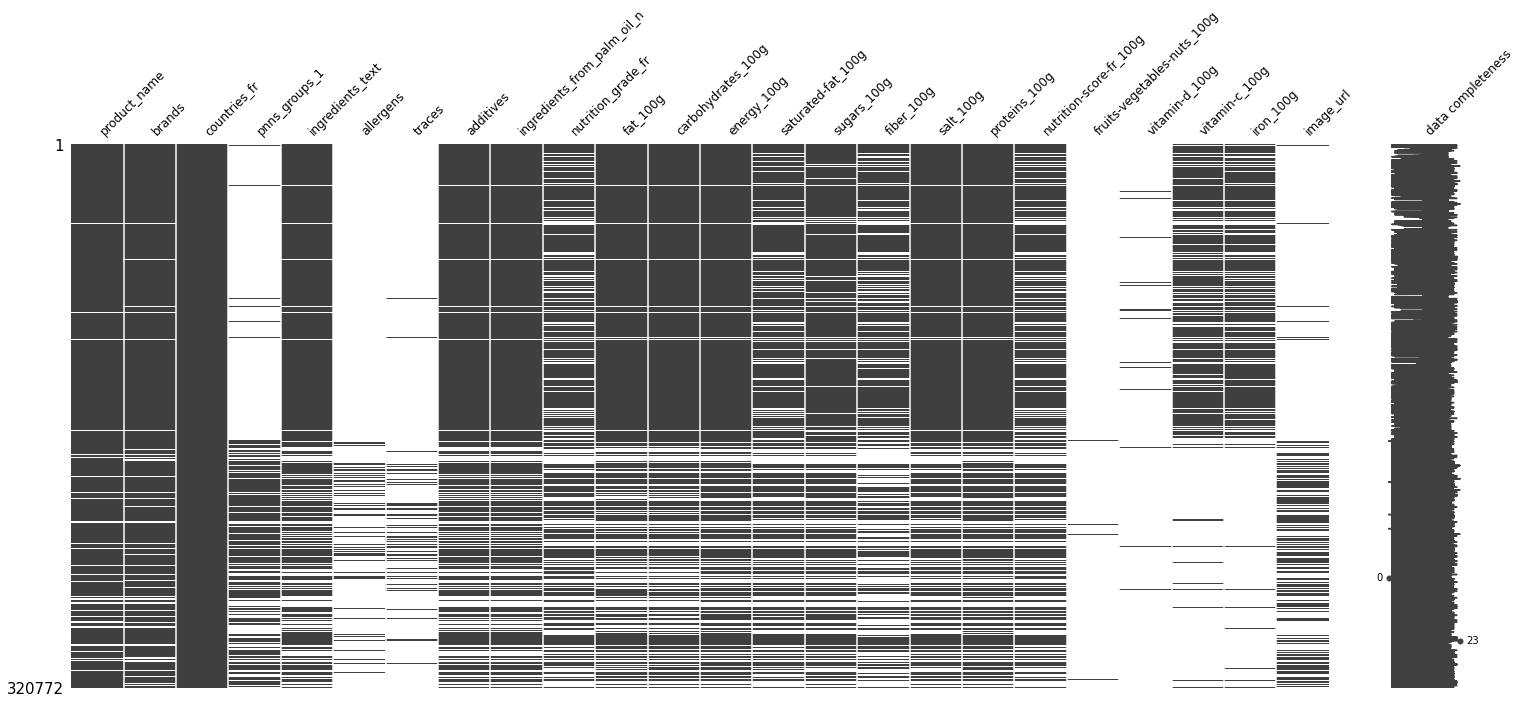

In [39]:
msno.matrix(df[ls_keep], labels=True, fontsize=12)

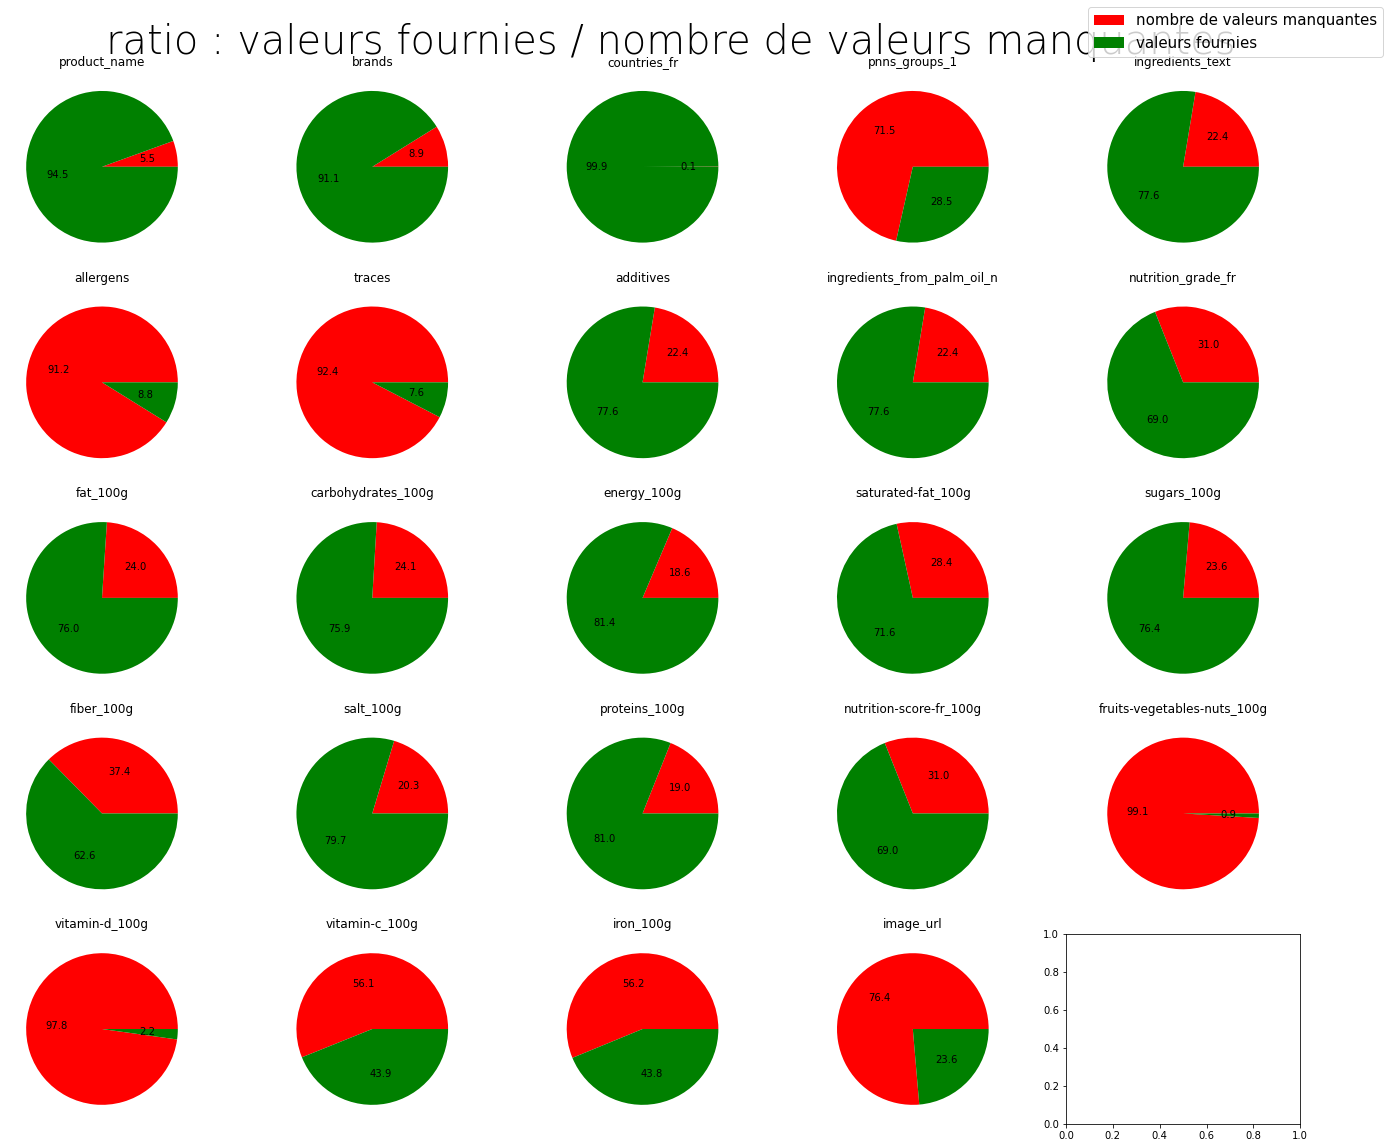

In [40]:
fillrate_pie(df[ls_keep])

#### Classement

Classons les colonnes suivant leur pourcentage de valeurs manquantes :

In [41]:
missing_value_df = get_missing_val_rates(df[ls_keep])
display(HTML(missing_value_df.to_html(index=False)))

column_name,percent_missing
fruits-vegetables-nuts_100g,99.053533
vitamin-d_100g,97.799995
traces,92.408003
allergens,91.163817
image_url,76.358286
pnns_groups_1,71.471014
iron_100g,56.211265
vitamin-c_100g,56.085007
fiber_100g,37.374210
nutrition_grade_fr,31.038245


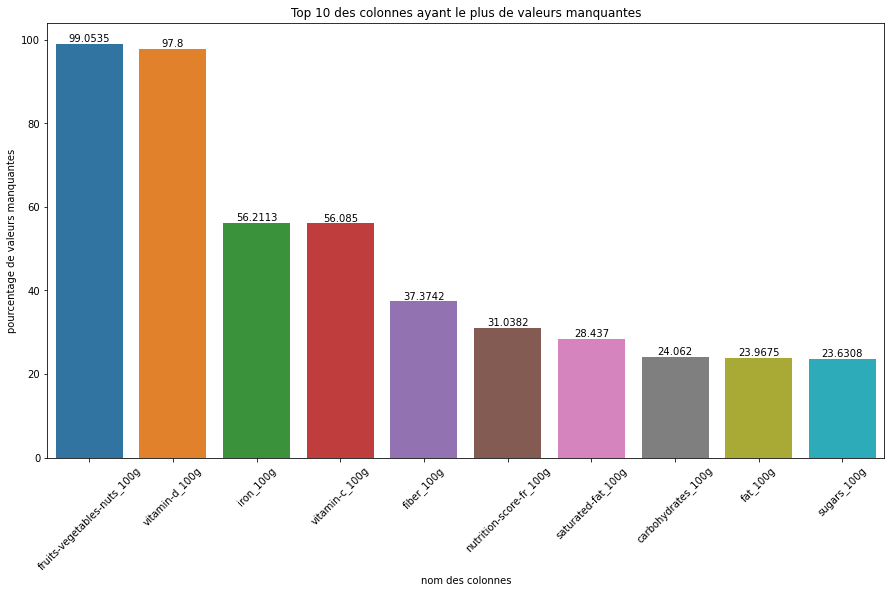

In [111]:
missing_value_df = missing_value_df.sort_values("percent_missing", ascending=False)
plt.figure(figsize=(15,8))
g = sns.barplot(x="column_name", y="percent_missing", data=missing_value_df.head(10))
g.bar_label(g.containers[0])
g.set(ylabel="pourcentage de valeurs manquantes", 
      xlabel="nom des colonnes", 
      title="Top 10 des colonnes ayant le plus de valeurs manquantes")
plt.xticks(rotation=45)
plt.show()

Pour les colonnes que nous gardons, celles qui ont le plus de valeurs manquantes sont des colonnes concernant des taux de nutriments pour 100g. Cette absence d'information est une information en elle-même, car il y a fort à parier que si ces champs sont manquants, le produit ne contient pas le nutriment en question.

Pour la suite, commençons par définir un nouveau dataframe, avec uniquement les colonnes que nous garderons, et que nous analyserons et nettoirons au fur-et-à-mesure.

In [42]:
df_clean = df[ls_keep]

In [43]:
# for col in ls_nutri_quanti_keep:
#     df_clean[col] = df_clean[col].fillna(0)

In [44]:
missing_value_df = get_missing_val_rates(df_clean[ls_nutri_quanti_keep])
display(HTML(missing_value_df.to_html(index=False)))

column_name,percent_missing
fruits-vegetables-nuts_100g,99.053533
vitamin-d_100g,97.799995
iron_100g,56.211265
vitamin-c_100g,56.085007
fiber_100g,37.374210
nutrition-score-fr_100g,31.038245
saturated-fat_100g,28.437021
carbohydrates_100g,24.061951
fat_100g,23.967491
sugars_100g,23.630803


## Analyse univariée et nettoyage

### Informations logistiques

In [45]:
ls_logistic_keep

['product_name', 'brands', 'countries_fr', 'pnns_groups_1']

#### Nom du produit ```product_name```

Il manque 5.54% de valeurs dans cette colonne. Essayons de déterminer s'il est possible de remplacer cette valeur par celle contenue dans ```generic_name```.
Pour cela, déterminons le nombre de lignes pour lequel aucune des deux valeurs n'est fournie :

In [46]:
print("Nombre de lignes où les deux valeurs sont manquantes : {}".format(df.loc[df["generic_name"].isna() & df["product_name"].isna()].shape[0]))
print("Nombre de lignes où la valeur manquante de product_name peut être remplacée par celle de generic_name : {}".format(df.loc[df["generic_name"].notna() & df["product_name"].isna()].shape[0]))

Nombre de lignes où les deux valeurs sont manquantes : 17643
Nombre de lignes où la valeur manquante de product_name peut être remplacée par celle de generic_name : 119


Remplaçons donc les valeurs manquantes. Ce n'est pas beaucoup, mais c'est mieux que rien.

In [47]:
df_clean["product_name"] = df["product_name"].fillna(df["generic_name"])

C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_30688/3005510696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["product_name"] = df["product_name"].fillna(df["generic_name"])


In [48]:
get_missing_val_rates(df_clean[["product_name"]])

,column_name,percent_missing
product_name,product_name,5.500168


,nb_unique,nb_manquants,% manquant,valeur la plus fréquente,% valeur la plus fréquente
0,221455,17643,5.500168,Ice Cream,0.135256


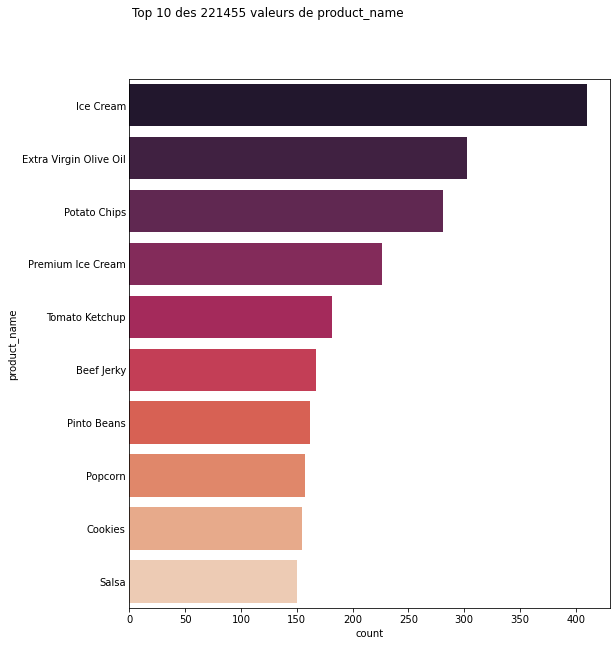

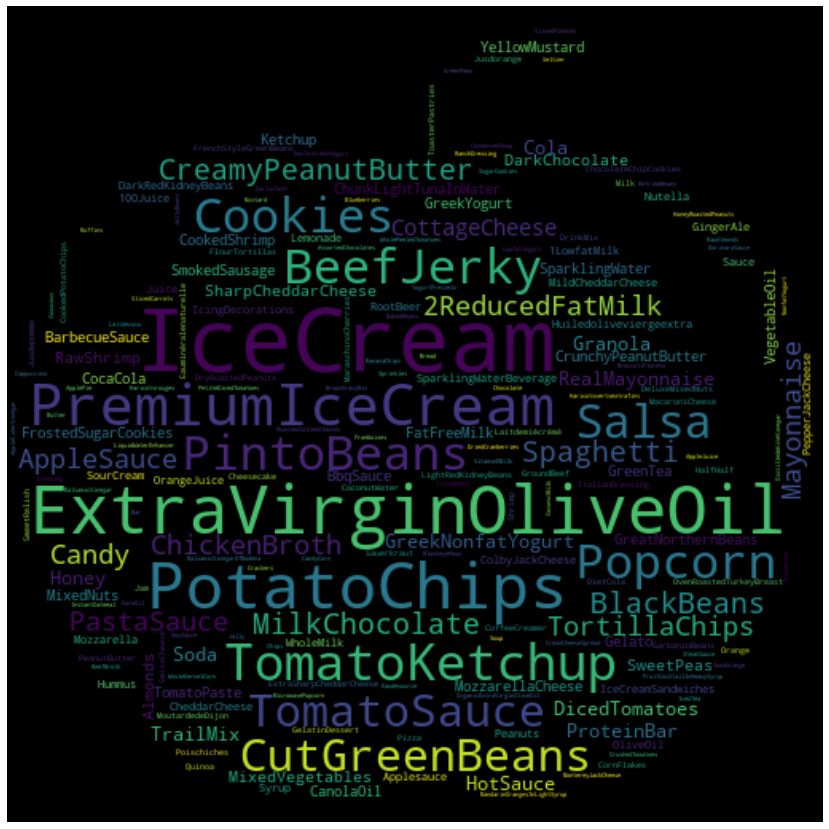

In [49]:
plot(df_clean, "product_name")

#### Marque du produit ```brands```

Il manque 8.86% de valeurs pour brands. Regardons si on peut les remplacer par les valeurs contenues dans ```brand_tags```

In [50]:
print("Nombre de lignes où les deux valeurs sont manquantes : {}".format(df.loc[df["brands_tags"].isna() & df["brands"].isna()].shape[0]))
print("Nombre de lignes où la valeur manquante de product_name peut être remplacée par celle de generic_name : {}".format(df.loc[df["brands_tags"].notna() & df["brands"].isna()].shape[0]))

Nombre de lignes où les deux valeurs sont manquantes : 28410
Nombre de lignes où la valeur manquante de product_name peut être remplacée par celle de generic_name : 2


On pourrait se dire que c'est toujours deux valeurs de gagnées, mais il y a un piège :

In [51]:
df.loc[df["brands_tags"].notna() & df["brands"].isna()][["brands", "brands_tags"]]

,brands,brands_tags
248232,NaN,na
248234,NaN,na


En regardant les deux lignes, on s'apperçoit que la valeur de brand_tags est une chaîne de caractères qui indique que la valeur n'est pas renseignée. On va donc laisser la colonne brands ainsi.

,nb_unique,nb_manquants,% manquant,valeur la plus fréquente,% valeur la plus fréquente
0,58784,28412,8.857382,Carrefour,1.018607


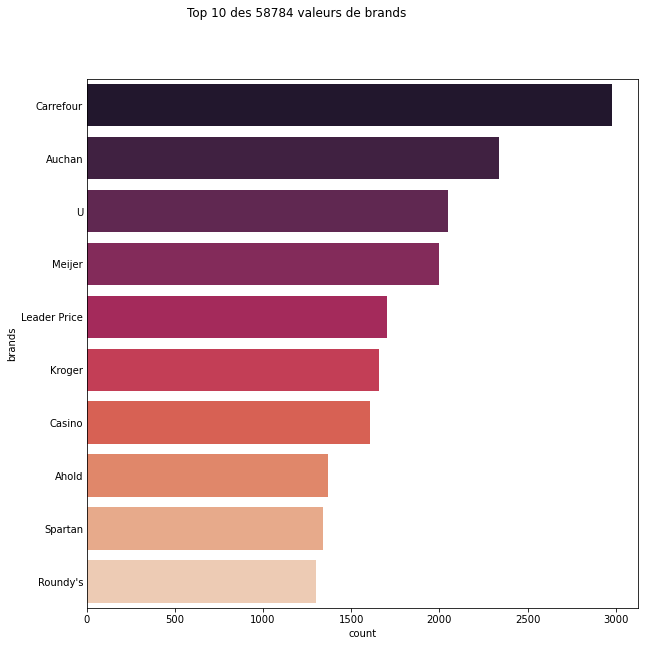

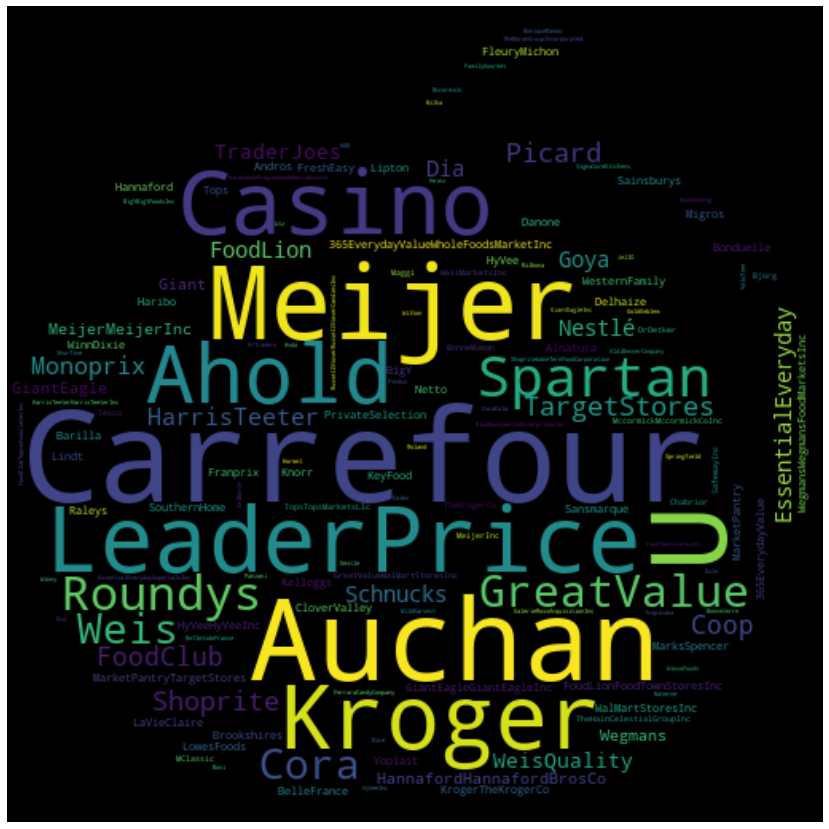

In [52]:
plot(df_clean, "brands")

#### Pays ```countries_fr```

Cette colonne nous servira à ne cibler que les produits disponibles en France. On ne gardera donc que les produits qui contiennent cette valeur.

In [53]:
df_clean = keep_only_french_products(df_clean)

In [54]:
df_clean.shape

(98440, 24)

#### Catégories Programme National Nutrition Santé, version 1 ```pnns_groups_1```

,nb_unique,nb_manquants,% manquant,valeur la plus fréquente,% valeur la plus fréquente
0,13,33559,34.090817,unknown,19.262958


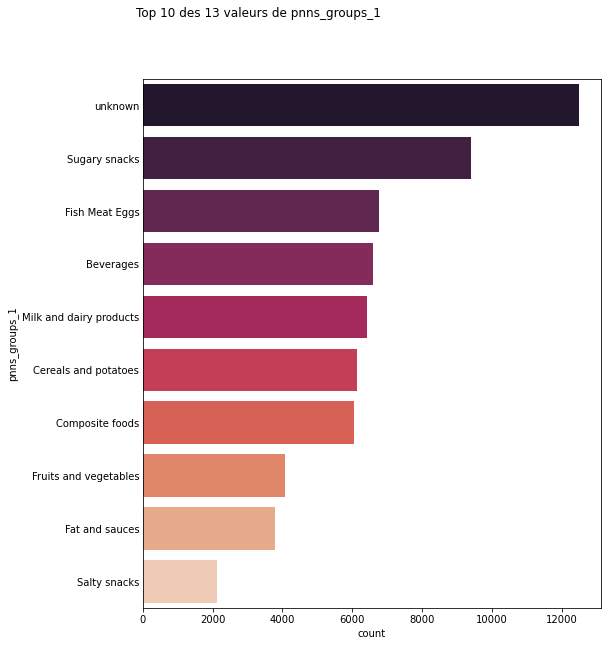

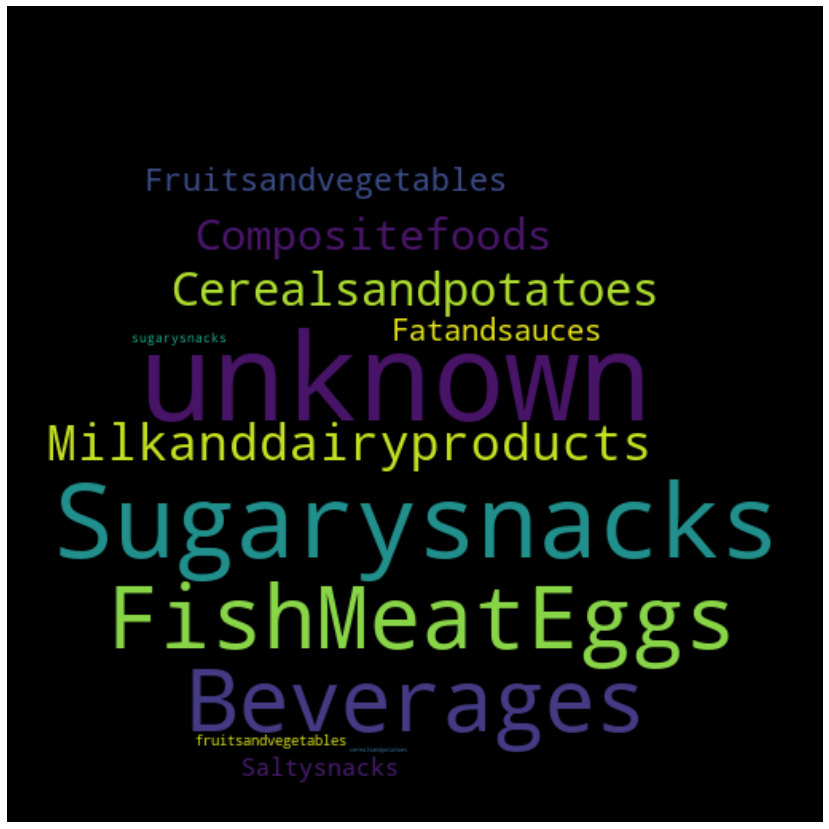

In [55]:
plot(df_clean, "pnns_groups_1")

Text(0.5, 1.0, 'Répartition des produits par pnns_groups_1')

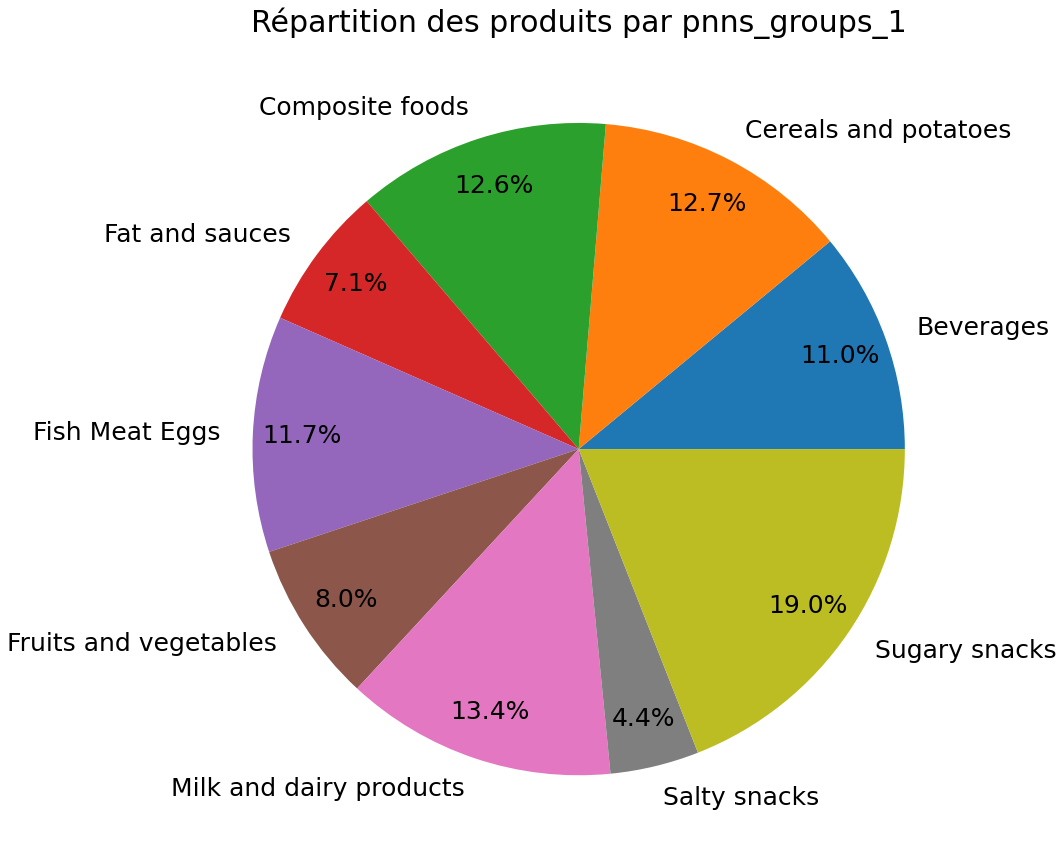

In [155]:
# pie_many_cols(df_clean, ["pnns_groups_1"], (35,35))


title = "Répartition des produits par pnns_groups_1"
fontsize = 25
dimensions = (15,15)

g =  df_clean.pnns_groups_1.value_counts().sort_index().plot.pie(figsize=dimensions,
                                         textprops={'fontsize': fontsize},
                                         autopct='%1.1f%%',
                                         pctdistance = 0.85)

plt.ylabel("")
plt.title(title, pad=10, size=30)

In [56]:
df_clean["pnns_groups_1"].unique().tolist()

[nan,
 'unknown',
 'Cereals and potatoes',
 'Sugary snacks',
 'Beverages',
 'Fish Meat Eggs',
 'Composite foods',
 'Fruits and vegetables',
 'Milk and dairy products',
 'Salty snacks',
 'Fat and sauces',
 'fruits-and-vegetables',
 'sugary-snacks',
 'cereals-and-potatoes']

Nous allons remplacer la valeur unknown par NaN, et la catégorie 'fruits-and-vegetables' par 'fruits and vegetables', la catégorie 'sugary-snacks' par 'sugary snacks', ainsi que la catégorie 'cereals-and-potatoes' par 'Cereals and potatoes' car ce sont des doublons.

In [57]:
df_clean["pnns_groups_1"] = df_clean["pnns_groups_1"].replace("unknown", np.nan)
df_clean["pnns_groups_1"] = df_clean["pnns_groups_1"].replace("fruits-and-vegetables", "fruits and vegetables")
df_clean["pnns_groups_1"] = df_clean["pnns_groups_1"].replace("sugary-snacks", "sugary snacks")
df_clean["pnns_groups_1"] = df_clean["pnns_groups_1"].replace("cereals-and-potatoes", "Cereals and potatoes")
df_clean["pnns_groups_1"] = df_clean["pnns_groups_1"].replace("sugary snacks", "Sugary snacks")
df_clean["pnns_groups_1"] = df_clean["pnns_groups_1"].replace("fruits and vegetables", "Fruits and vegetables")
df_clean["pnns_groups_1"].unique().tolist()

[nan,
 'Cereals and potatoes',
 'Sugary snacks',
 'Beverages',
 'Fish Meat Eggs',
 'Composite foods',
 'Fruits and vegetables',
 'Milk and dairy products',
 'Salty snacks',
 'Fat and sauces']

Nous avons maintenant 9 catégories

### Informations nutritionnelles qualitatives

In [58]:
ls_nutri_quali_keep

['ingredients_text',
 'allergens',
 'traces',
 'additives',
 'ingredients_from_palm_oil_n',
 'nutrition_grade_fr']

#### Liste des ingrédients ```ingredients_text```

,nb_unique,nb_manquants,% manquant,valeur la plus fréquente,% valeur la plus fréquente
0,49105,44974,45.686713,Semoule de _blé_ dur de qualité supérieure.,0.205738


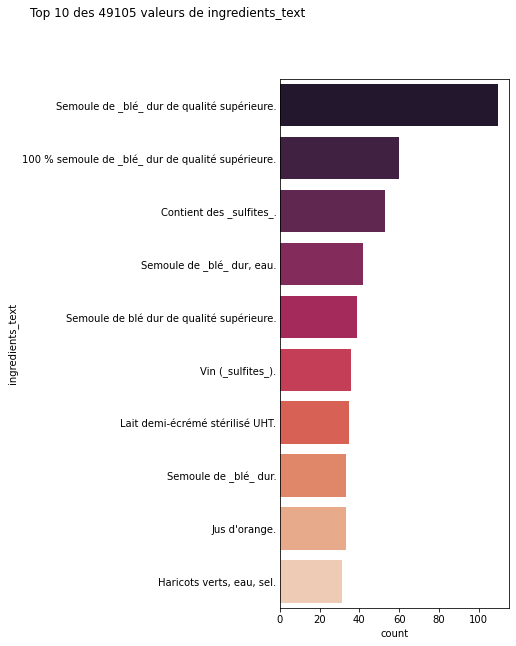

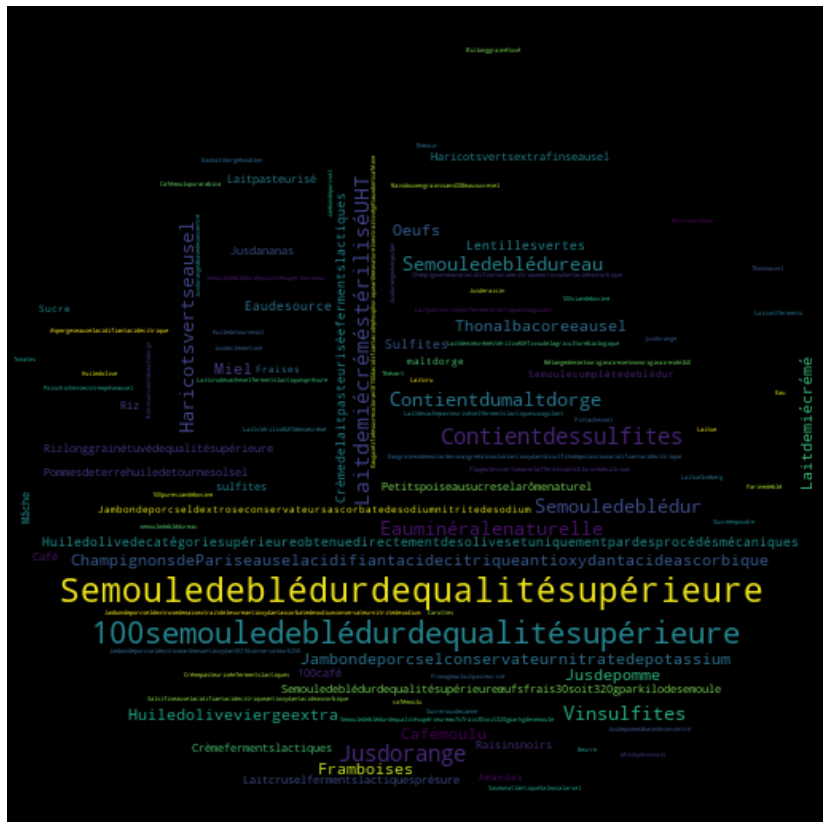

In [59]:
plot(df_clean, "ingredients_text")

#### Produits allergènes ```allergens```

,nb_unique,nb_manquants,% manquant,valeur la plus fréquente,% valeur la plus fréquente
0,9974,75536,76.733035,blé,5.527419


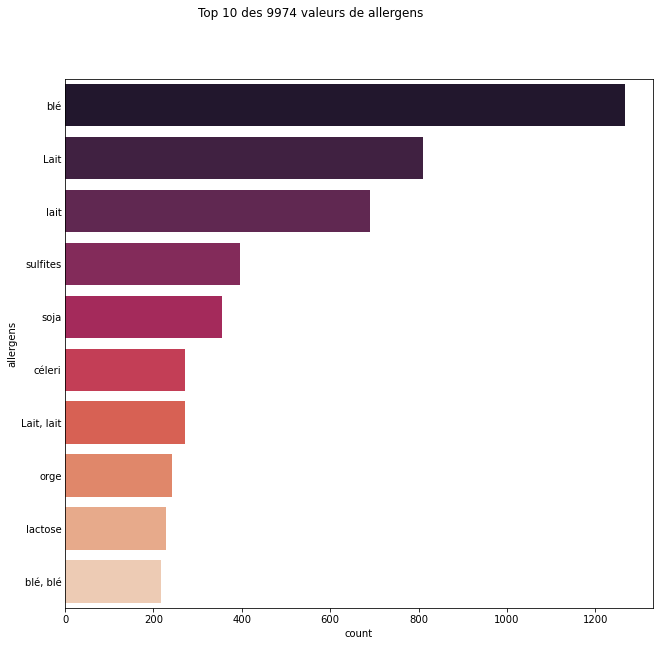

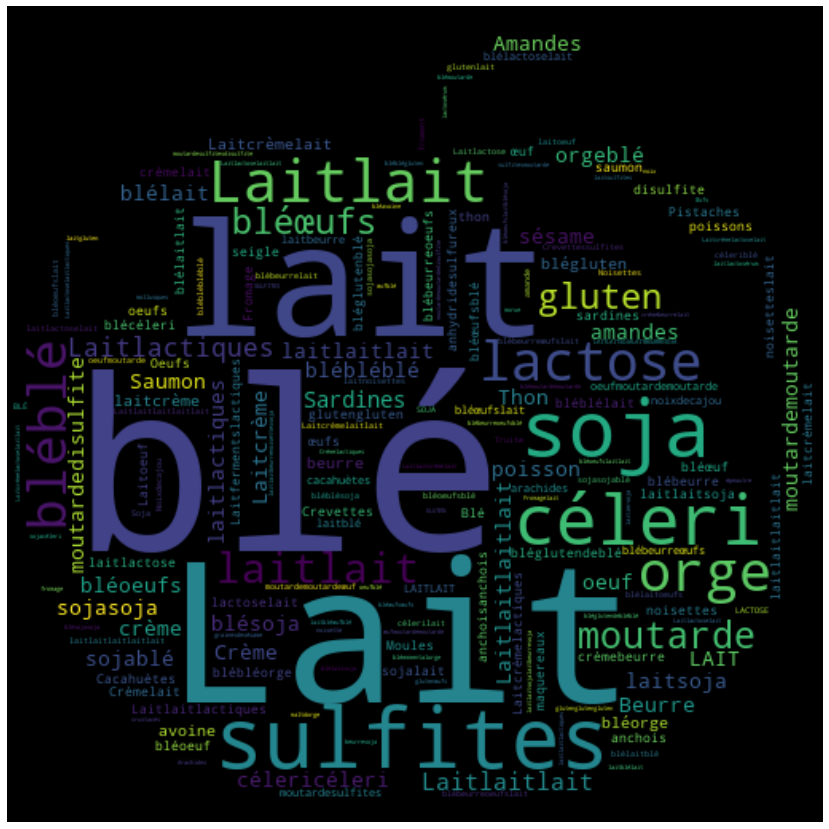

In [60]:
plot(df_clean, "allergens")

Nous considérerons que lorsque la valeur n'est pas renseignée, le produit ne contient pas d'allergènes

#### Traces ```traces```

,nb_unique,nb_manquants,% manquant,valeur la plus fréquente,% valeur la plus fréquente
0,5922,79276,80.532304,Fruits à coque,6.40263


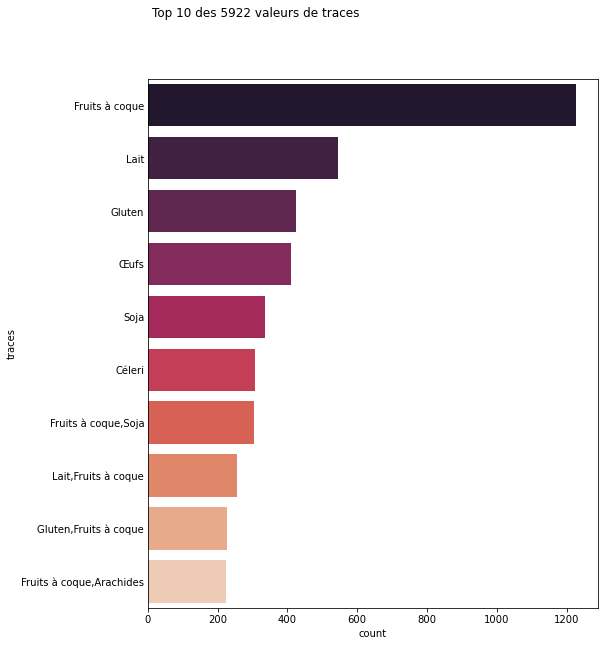

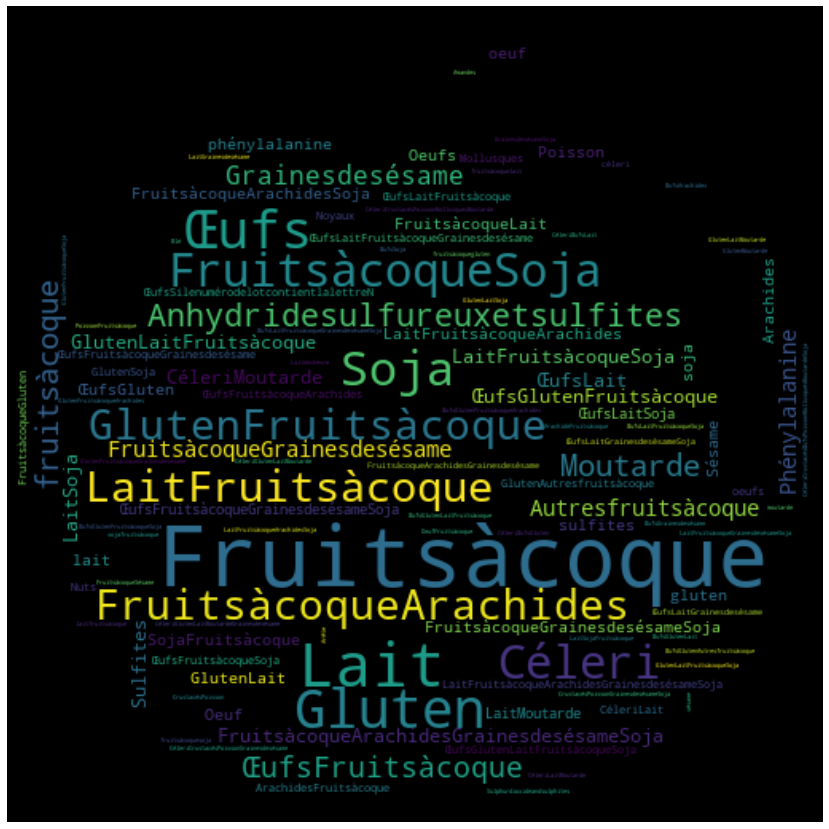

In [61]:
plot(df_clean, "traces")

De la même manière que pour la colonne ```allergens```, nous considérerons que lorsque la valeur n'est pas renseignée, le produit ne contient pas de trace d'allergènes

#### Ingrédients provenant de l'huile de palme ```ingredients_from_palm_oil_n```

Cette colonne nous indique le nombre d'ingrédients du produit frabriqué à partir d'huile de palme

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,3,44974,45.686713,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.069839,0.258593,0.06687,3734.0,11.33933,370.271344


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


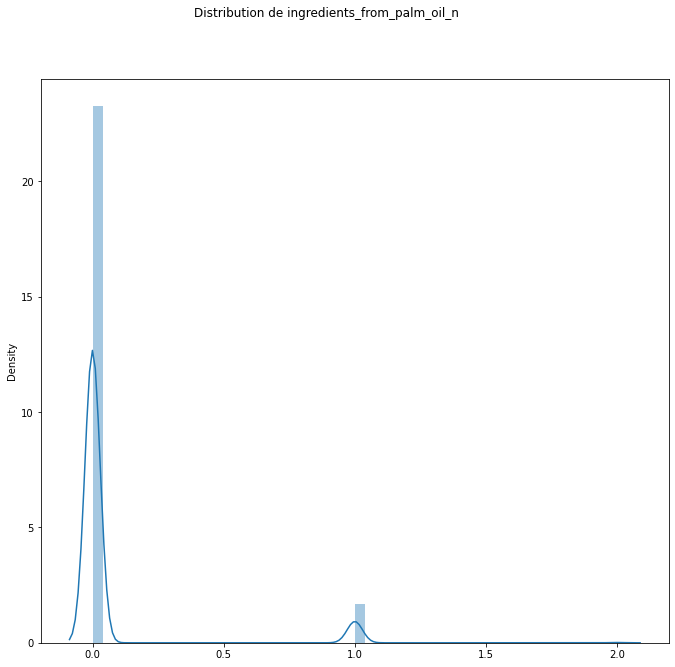

In [63]:
plot(df_clean, "ingredients_from_palm_oil_n")

Nous considèrerons que lorsque aucune valeur n'est fournie, c'est que le produit n'en contient aucun. Remplaçons donc les NaN par 0.0 :

In [64]:
df_clean["ingredients_from_palm_oil_n"] = df_clean["ingredients_from_palm_oil_n"].fillna(0)

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.037932,0.193725,0.037529,3734.0,24.896297,510.720713


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


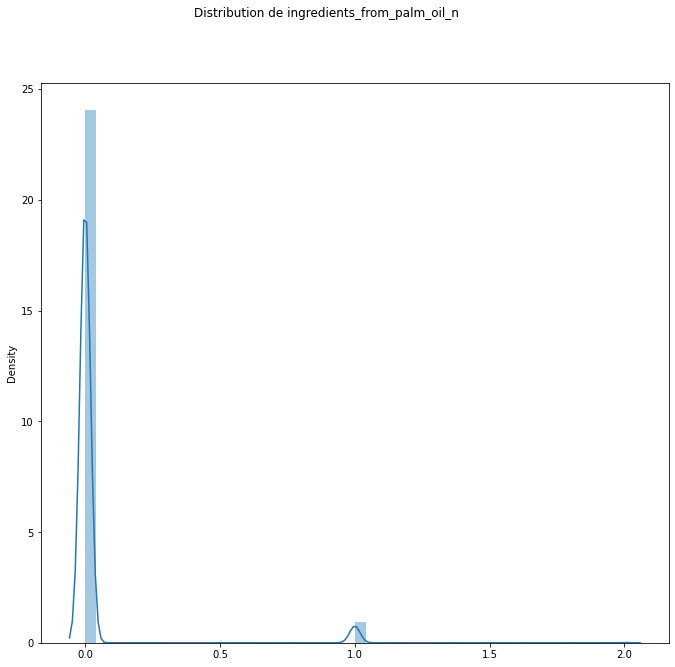

In [65]:
plot(df_clean, "ingredients_from_palm_oil_n")

#### Nutri-score ```nutrition_grade_fr```

Il s'agit d'une lettre de A à E qui nous renseigne sur le rang nutritionnel du produit, A étant la meilleur note, E la pire. Pour les valeurs manquantes, on pourra éventuellement les déduire de la colonne ```nutrition-score-fr_100g```

,nb_unique,nb_manquants,% manquant,valeur la plus fréquente,% valeur la plus fréquente
0,5,37025,37.611743,d,27.66588


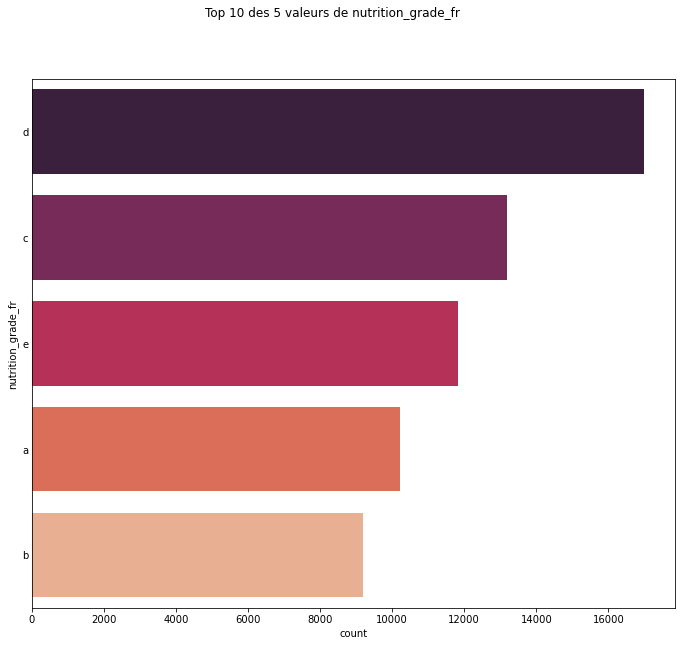

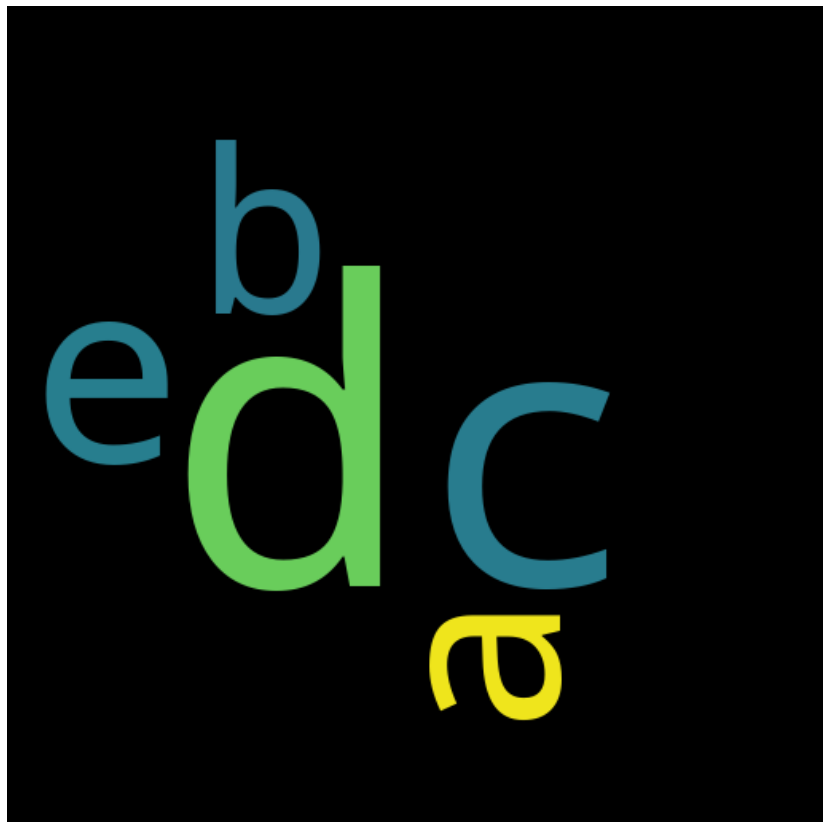

In [66]:
plot(df_clean, "nutrition_grade_fr")

Text(0.5, 1.0, 'Répartition des nutriscores')

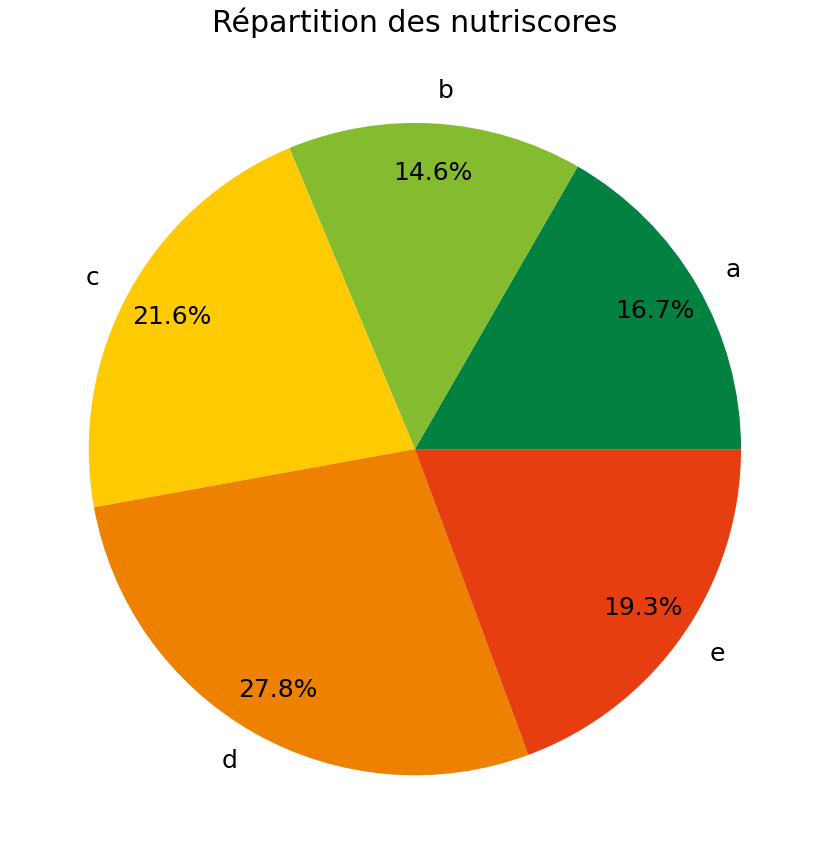

In [153]:
palette_nutrigrade = ["#038141", "#85BB2F", "#FECB02", "#EE8100", "#E63E11", "#353535"]
title = "Répartition des nutriscores"
fontsize = 25
dimensions = (15,15)

g =  df_clean.nutrition_grade_fr.value_counts().sort_index().plot.pie(figsize=dimensions,
                                         textprops={'fontsize': fontsize},
                                         autopct='%1.1f%%',
                                         pctdistance = 0.85,
                                         colors = palette_nutrigrade)

plt.ylabel("")
plt.title(title, pad=10, size=30)

### Informations nutritionnelles quantitatives

In [67]:
df[ls_nutri_quanti_keep].columns.tolist()

['fat_100g',
 'carbohydrates_100g',
 'energy_100g',
 'saturated-fat_100g',
 'sugars_100g',
 'fiber_100g',
 'salt_100g',
 'proteins_100g',
 'nutrition-score-fr_100g',
 'fruits-vegetables-nuts_100g',
 'vitamin-d_100g',
 'vitamin-c_100g',
 'iron_100g']

##### Limitations des valeurs entre 0 et 100

Les colonnes qu'il faudra limiter entre 0 et 100 sont les suivantes :

In [68]:
ls_limit_0_100 = [
    "fat_100g",
    "carbohydrates_100g",
    "saturated-fat_100g",
    "sugars_100g",
    "fiber_100g",
    "salt_100g",
    "proteins_100g",
    "fruits-vegetables-nuts_100g",
    "vitamin-d_100g",
    "vitamin-c_100g",
    "iron_100g"
]

Commençons par remplacer les valeurs hors-limite dans ces colonnes par NaN. Plus tard, nous supprimerons les lignes ne contenant que des NaN ou des valeurs nulles

In [69]:
for col in ls_limit_0_100:
    limit_col(df_clean, col, 0.0, 100.0)

C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_30688/2948985923.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col]<inf] = None
C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_30688/2948985923.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col]>sup] = None


In [70]:
df_clean[ls_limit_0_100].describe()

,fat_100g,carbohydrates_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g,proteins_100g,fruits-vegetables-nuts_100g,vitamin-d_100g,vitamin-c_100g,iron_100g
count,47640.000000,47203.000000,62374.000000,62510.000000,45722.000000,62572.000000,64318.000000,2971.000000,591.000000,1297.000000,1185.000000
mean,13.322612,27.742536,5.420416,13.427256,2.555434,1.155202,7.754531,31.546439,0.000005,0.125570,0.044379
std,16.838255,27.382320,8.491734,19.074751,4.561634,4.198362,7.887373,32.055360,0.000018,2.800254,0.757976
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.300000,4.000000,0.300000,1.000000,0.000000,0.080000,1.800000,0.000000,0.000001,0.012000,0.002400
50%,6.800000,14.500000,2.000000,4.100000,1.380000,0.558800,6.000000,24.000000,0.000002,0.020000,0.005000
75%,21.000000,53.000000,7.400000,17.800000,3.200000,1.244600,11.000000,51.000000,0.000005,0.030000,0.008000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000376,100.000000,25.000000


In [71]:
get_missing_val_rates(df_clean[ls_limit_0_100])

,column_name,percent_missing
vitamin-d_100g,vitamin-d_100g,99.399634
iron_100g,iron_100g,98.796221
vitamin-c_100g,vitamin-c_100g,98.682446
fruits-vegetables-nuts_100g,fruits-vegetables-nuts_100g,96.981918
fiber_100g,fiber_100g,53.553434
carbohydrates_100g,carbohydrates_100g,52.048964
fat_100g,fat_100g,51.605039
saturated-fat_100g,saturated-fat_100g,36.637546
sugars_100g,sugars_100g,36.499390
salt_100g,salt_100g,36.436408


Supprimons les lignes dont toutes les colonnes quantitatives sont manquantes ou toutes nulles.

In [72]:
df_clean = df_clean.loc[~(df_clean[ls_nutri_quanti_keep].isna()).all(axis=1)]
df_clean[ls_limit_0_100].head()

,fat_100g,carbohydrates_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g,proteins_100g,fruits-vegetables-nuts_100g,vitamin-d_100g,vitamin-c_100g,iron_100g
106,20.00,70.00,12.5,57.5,2.5,0.09652,2.50,NaN,NaN,NaN,0.00090
138,4.17,77.08,NaN,NaN,6.2,NaN,6.25,NaN,NaN,NaN,0.00075
190,NaN,NaN,0.8,87.7,0.9,0.01000,0.60,NaN,NaN,NaN,NaN
191,NaN,NaN,2.9,50.3,3.9,0.00300,9.50,NaN,NaN,NaN,NaN
226,0.00,10.40,0.0,10.4,0.0,0.02540,0.00,NaN,NaN,NaN,NaN


In [73]:
df_clean = df_clean.loc[~((df_clean[ls_limit_0_100]==0.0)|(df_clean[ls_limit_0_100].isna())).all(axis=1)]
df_clean[ls_limit_0_100].shape

(64958, 11)

Maintenant que ce premier nettoyage est fait, analysons chacunes de ces colonnes:

#### Graisses pour 100g ```fat_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,1194,17447,26.858893,0.0,0.0,1.3,6.9,21.0,42.7,100.0,100.0,19.7,13.358785,16.846763,283.813428,634689.220633,6.491484,126.109998


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


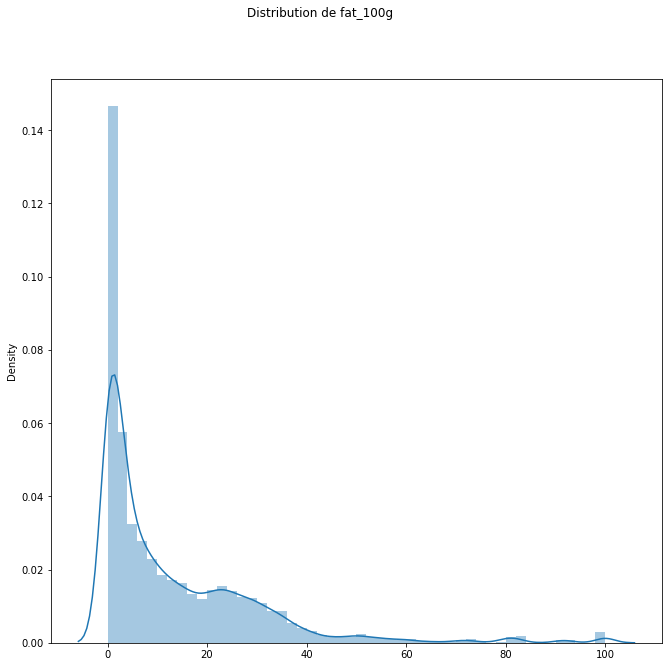

In [74]:
plot(df_clean, "fat_100g")

#### Glucides pour 100g ```carbohydrates_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,1428,17880,27.525478,0.0,0.2,4.1,14.6,53.0,76.1,100.0,100.0,48.9,27.816197,27.381258,749.733314,1.309531e+06,-0.943797,98.436385


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


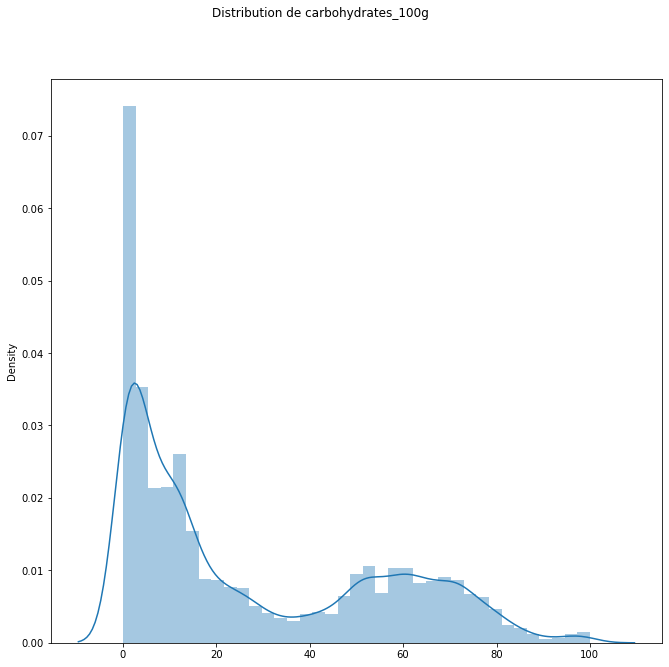

In [75]:
plot(df_clean, "carbohydrates_100g")

#### Graisses saturées pour 100g ```saturated-fat_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,1212,2813,4.33049,0.0,0.0,0.3,2.0,7.5,20.0,100.0,100.0,7.2,5.44039,8.500976,72.266598,338093.01673,20.661199,156.256754


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


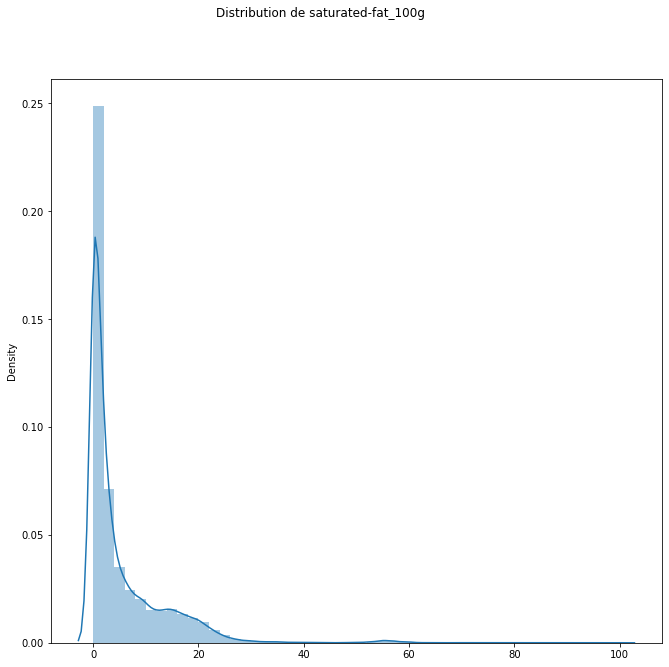

In [76]:
plot(df_clean, "saturated-fat_100g")

#### Sucres pour 100g ```sugars_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,1483,2681,4.127282,0.0,0.0,1.0,4.1,18.0,56.5,100.0,100.0,17.0,13.477493,19.092678,364.530337,839337.80188,3.197902,141.663425


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


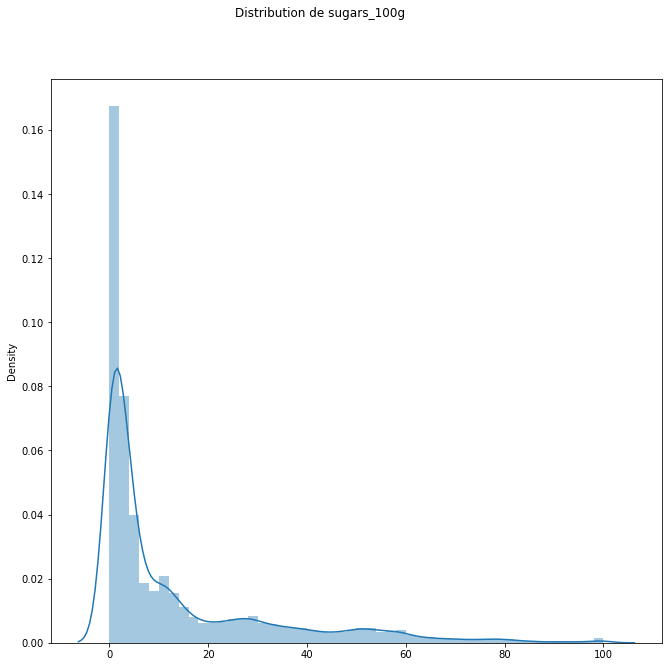

In [77]:
plot(df_clean, "sugars_100g")

#### Fibres pour 100g ```fiber_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,754,19441,29.928569,0.0,0.0,0.0,1.4,3.2,9.1,100.0,100.0,3.2,2.566943,4.568663,20.872684,116839.563,97.611592,177.980679


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


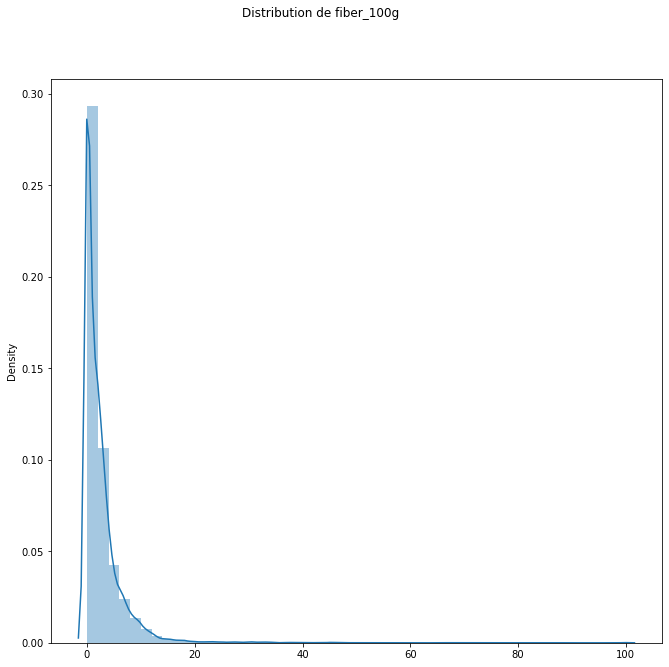

In [78]:
plot(df_clean, "fiber_100g")

#### Sel pour 100g ```salt_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,2597,2635,4.056467,0.0,0.0,0.08,0.56,1.25,3.0,100.0,100.0,1.17,1.159818,4.206105,17.691315,72283.308869,300.078899,362.652258


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


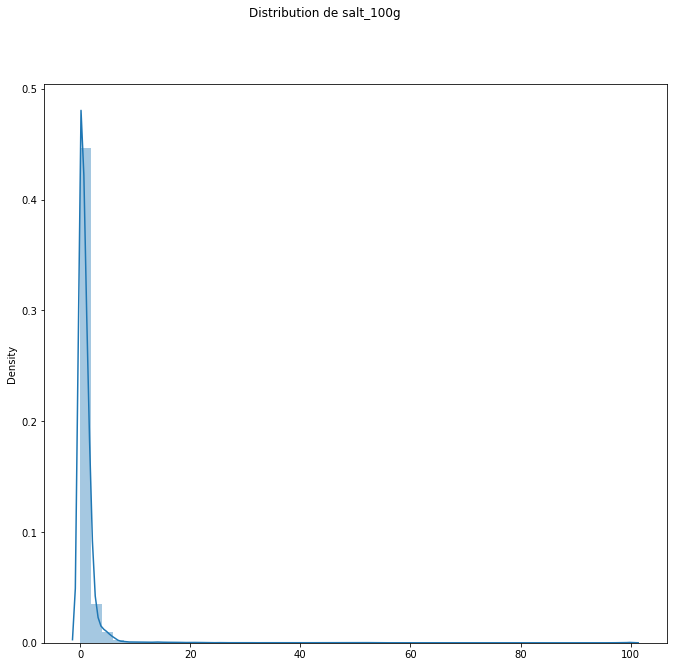

In [79]:
plot(df_clean, "salt_100g")

#### Protéines pour 100g ```proteins_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,1127,890,1.370116,0.0,0.0,1.9,6.0,11.0,23.0,100.0,100.0,9.1,7.78479,7.887829,62.217849,498755.9475,11.801459,101.323592


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


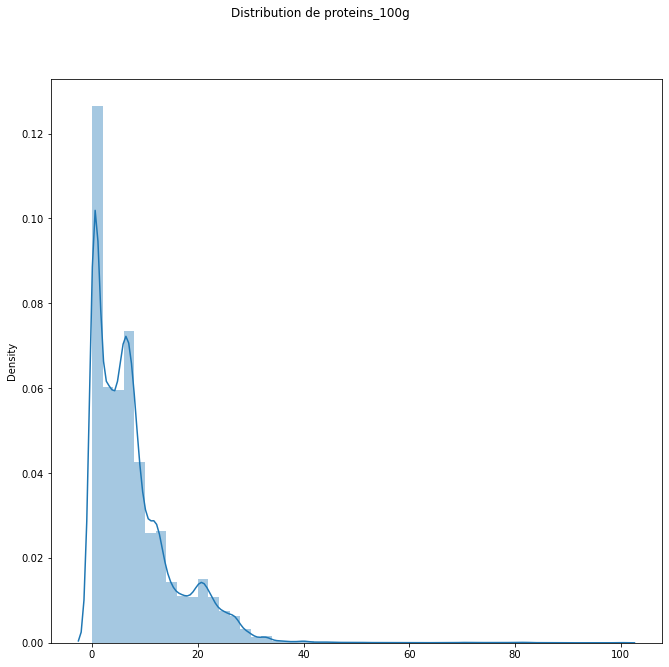

In [80]:
plot(df_clean, "proteins_100g")

#### Fruits à coque pour 100g ```fruits-vegetables-nuts_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,328,62002,95.449367,0.0,0.0,0.0,24.1,51.575,100.0,100.0,100.0,51.575,31.706519,32.057523,1027.684756,93724.47,-0.729851,101.107039


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


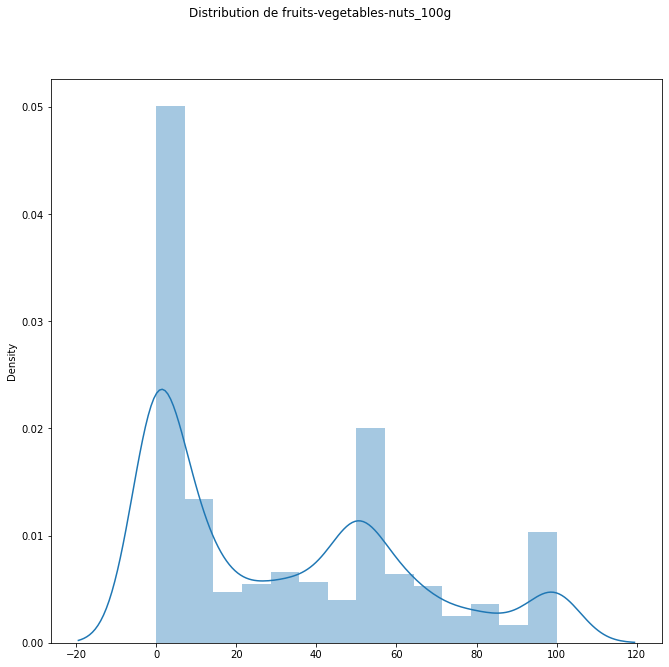

In [81]:
plot(df_clean, "fruits-vegetables-nuts_100g")

#### Vitamine D pour 100g ```vitamin-d_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,115,64367,99.090181,0.0,7.500000e-07,0.000001,0.000002,0.000005,0.000012,0.000376,0.000376,0.000004,0.000005,0.000018,3.231314e-10,0.003147,311.565901,337.581099


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


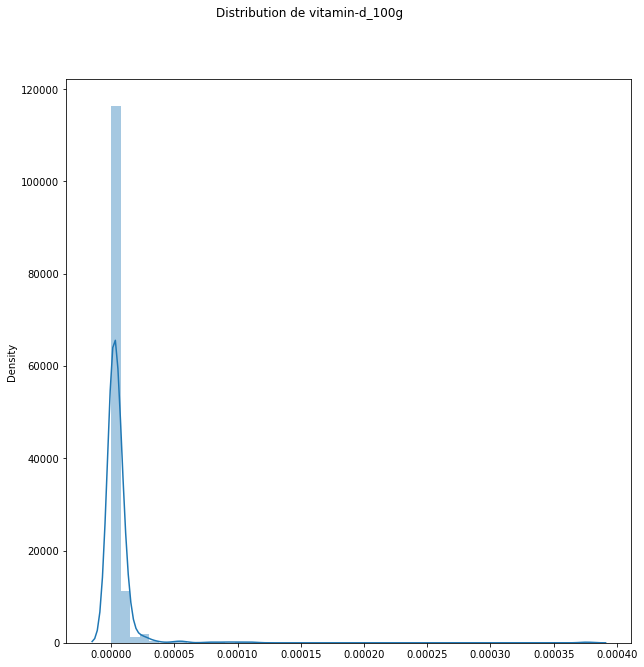

In [82]:
plot(df_clean, "vitamin-d_100g")

#### Vitamine C pour 100g ```vitamin-c_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,213,63661,98.003325,0.0,0.0,0.012,0.02,0.03,0.075,100.0,100.0,0.018,0.12557,2.800254,7.841425,162.864515,1251.507368,2230.03155


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


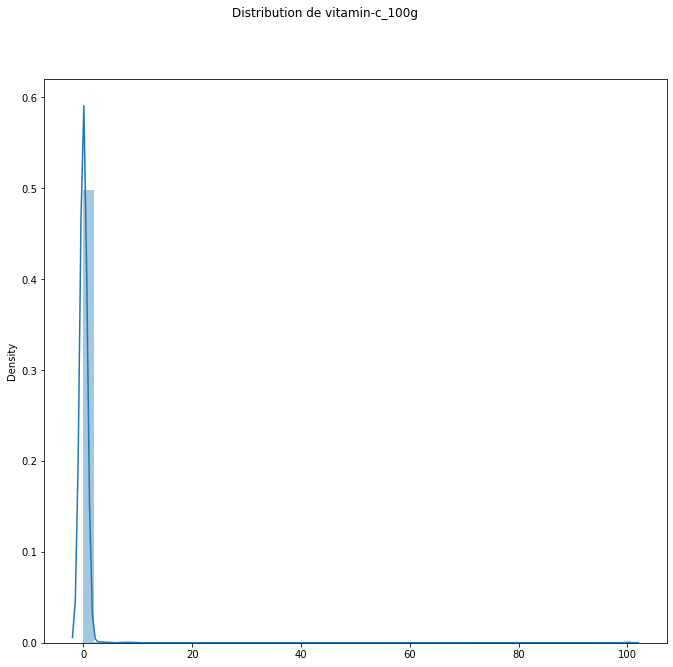

In [83]:
plot(df_clean, "vitamin-c_100g")

#### Fer pour 100g ```iron_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,284,63773,98.175744,0.0,0.0,0.0024,0.005,0.008,0.016,25.0,25.0,0.0056,0.044379,0.757976,0.574527,52.589135,995.927089,1707.959677


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


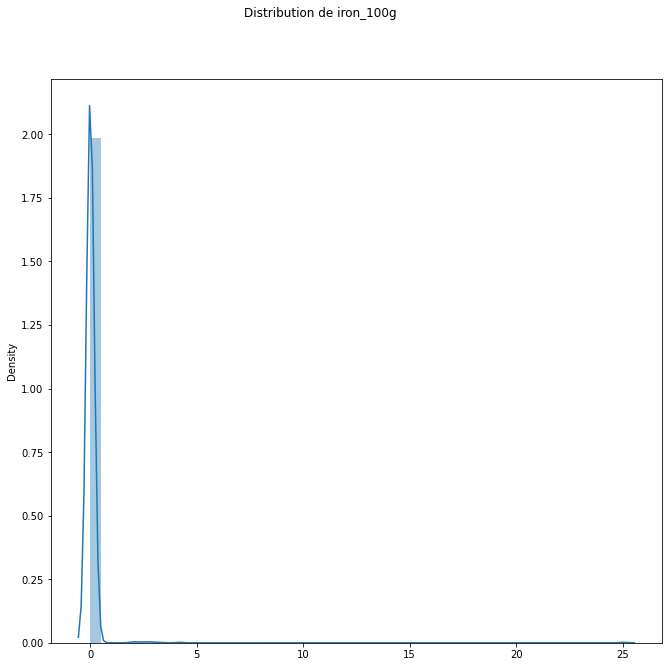

In [84]:
plot(df_clean, "iron_100g")

#### remplacement des valeurs manquantes des taux de nutriments par 0

In [85]:
# for col in ls_limit_0_100:
#      df_clean[col] = df_clean[col].fillna(0)

#### Vérification de la somme des colonnes

Pour chaque produit, la somme des taux de nutriments pour 100g ne doit pas dépasser 100. Regardons s'il y a des colonnes où c'est le cas

Commençons par créer une copie du dataset pour ces colonnes où nous remplacerons les valeurs manquantes par 0.

In [86]:
df_check_nutri = df_clean[ls_limit_0_100]
for col in ls_limit_0_100:
     df_check_nutri[col] = df_check_nutri[col].fillna(0)
get_missing_val_rates(df_check_nutri)

C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_30688/2116154856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_check_nutri[col] = df_check_nutri[col].fillna(0)


,column_name,percent_missing
fat_100g,fat_100g,0.0
carbohydrates_100g,carbohydrates_100g,0.0
saturated-fat_100g,saturated-fat_100g,0.0
sugars_100g,sugars_100g,0.0
fiber_100g,fiber_100g,0.0
salt_100g,salt_100g,0.0
proteins_100g,proteins_100g,0.0
fruits-vegetables-nuts_100g,fruits-vegetables-nuts_100g,0.0
vitamin-d_100g,vitamin-d_100g,0.0
vitamin-c_100g,vitamin-c_100g,0.0


Récupérons les lignes dont la somme des nutriments pour 100g dépasse 100.

Créons une nouvelle colonne qui contiendra la somme des nutriments pour 100g

In [87]:
df_check_nutri["somme_nutriments"] = df_check_nutri[ls_limit_0_100].sum(axis=1)
df_check_nutri.sample(10)

C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_30688/137403533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_check_nutri["somme_nutriments"] = df_check_nutri[ls_limit_0_100].sum(axis=1)


,fat_100g,carbohydrates_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g,proteins_100g,fruits-vegetables-nuts_100g,vitamin-d_100g,vitamin-c_100g,iron_100g,somme_nutriments
245314,4.6,11.2,1.2,1.7,1.7,0.7300,3.9,44.0,0.0,0.0,0.0,69.0300
242011,2.3,87.0,1.8,47.0,1.3,0.2750,4.1,0.0,0.0,0.0,0.0,143.7750
208561,0.0,0.0,0.5,5.2,3.8,0.4000,2.9,0.0,0.0,0.0,0.0,12.8000
243330,4.2,72.0,0.5,4.4,7.2,1.3600,11.3,0.0,0.0,0.0,0.0,100.9600
197067,0.0,100.0,0.0,100.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,200.0000
218561,8.5,74.2,0.0,0.0,0.0,0.0000,3.7,0.0,0.0,0.0,0.0,86.4000
202221,4.3,49.2,0.4,6.5,2.5,1.0750,8.5,0.0,0.0,0.0,0.0,72.4750
227587,0.6,78.0,0.1,0.3,0.9,0.0254,7.6,0.0,0.0,0.0,0.0,87.5254
204243,0.0,0.0,11.0,2.4,2.1,1.1000,8.0,0.0,0.0,0.0,0.0,24.6000
298425,32.0,60.5,16.5,60.0,1.3,0.8300,3.1,0.0,0.0,0.0,0.0,174.2300


On remarque qu'il y a des lignes où la somme des nutriments pour 100g est nulle. Regardons pour quelle proportion de lignes c'est le cas :

In [88]:
print("Il y a {} produits qui ne contiennent aucune information sur les nutriments."
      .format((df_check_nutri["somme_nutriments"]
               .loc[df_check_nutri["somme_nutriments"]==0]
               .shape[0]/df_check_nutri.shape[0])*100))

Il y a 0.0 produits qui ne contiennent aucune information sur les nutriments.


Maintenant, regardons combien de ligne ont une somme des nutriments supérieure à 100:

In [89]:
print("Il y a {} lignes dont la somme des nutriments dépasse 100".format(df_check_nutri.loc[df_check_nutri["somme_nutriments"] > 100].shape[0]))

Il y a 13185 lignes dont la somme des nutriments dépasse 100


En voici un échantillon :

In [90]:
df_check_nutri.loc[df_check_nutri["somme_nutriments"] > 100].sample(10)

,fat_100g,carbohydrates_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g,proteins_100g,fruits-vegetables-nuts_100g,vitamin-d_100g,vitamin-c_100g,iron_100g,somme_nutriments
240768,23.1,63.3,14.0,28.4,4.0,0.59944,6.6,0.0,0.0,0.0,0.0,139.99944
245479,0.3,3.5,0.1,2.3,2.0,0.10000,1.5,100.0,0.0,0.0,0.0,109.80000
286765,24.0,54.0,12.0,37.0,5.0,0.35560,11.0,0.0,0.0,0.0,0.0,143.35560
215818,26.0,60.0,13.0,29.5,0.0,1.50000,6.0,0.0,0.0,0.0,0.0,136.00000
282581,1.0,89.2,1.0,75.9,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,167.10000
272814,9.0,73.0,3.5,31.0,1.5,0.77000,4.5,0.0,0.0,0.0,0.0,123.27000
242771,72.3,11.3,7.0,4.9,2.9,0.81500,8.9,0.0,0.0,0.0,0.0,108.11500
252530,13.0,59.0,10.0,34.0,0.0,0.50000,5.0,0.0,0.0,0.0,0.0,121.50000
235754,48.0,36.0,10.0,32.0,0.0,0.01000,8.0,0.0,0.0,0.0,0.0,134.01000
199258,8.5,5.5,0.8,2.0,0.0,1.20000,3.0,82.0,0.0,0.0,0.0,103.00000


Hypothèse : peut-être que les graisses saturées sont comprises dans les graisses.
Créons une nouvelle colonne ```somme_nutriments_2``` où nous n'inclurons pas la colonne ```saturated-fat_100g``` dans le calcul

In [91]:
ls_col_tu_sum = [
    'fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
    'salt_100g',
    'proteins_100g',
    'fruits-vegetables-nuts_100g',
    'vitamin-d_100g',
    'vitamin-c_100g',
    'iron_100g'
]

df_check_nutri["somme_nutriments_2"] = df_check_nutri[ls_col_tu_sum].sum(axis=1)
df_check_nutri.sample(10)

C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_30688/2086060076.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_check_nutri["somme_nutriments_2"] = df_check_nutri[ls_col_tu_sum].sum(axis=1)


,fat_100g,carbohydrates_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g,proteins_100g,fruits-vegetables-nuts_100g,vitamin-d_100g,vitamin-c_100g,iron_100g,somme_nutriments,somme_nutriments_2
262934,0.0,12.0,0.0,12.0,0.0,0.0000,0.0,0.0,0.000000,0.000,0.0000,24.000000,24.000000
178510,0.0,0.0,30.3,1.5,23.4,0.1500,12.4,0.0,0.000000,0.000,0.0000,67.750000,37.450000
246041,22.7,0.0,2.0,0.1,0.0,2.5400,19.1,0.0,0.000000,0.000,0.0000,46.440000,44.440000
219226,5.5,7.0,2.6,0.9,1.5,0.4100,6.6,0.0,0.000000,0.000,0.0000,24.510000,21.910000
214927,0.0,0.0,0.4,3.2,7.2,0.1000,14.0,0.0,0.000000,0.000,0.0000,24.900000,24.500000
259609,0.0,59.8,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000,0.0000,59.800000,59.800000
229559,24.7,53.8,10.1,53.2,4.1,0.3175,9.7,0.0,0.000009,0.068,0.0039,155.989409,145.889409
292678,0.0,0.0,0.2,84.8,0.9,0.0600,0.4,0.0,0.000000,0.000,0.0000,86.360000,86.160000
302747,0.0,0.0,2.3,2.0,2.8,2.0000,15.1,0.0,0.000000,0.000,0.0000,24.200000,21.900000
190154,1.2,81.0,0.3,0.5,1.7,0.0200,7.0,0.0,0.000000,0.000,0.0000,91.720000,91.420000


Regardons à nouveau pour combien de produits la somme des nutriments pour 100g dépasse 100 :

In [92]:
print("Il y a {} lignes dont la somme des nutriments dépasse 100".format(df_check_nutri.loc[df_check_nutri["somme_nutriments_2"] > 100].shape[0]))

Il y a 11298 lignes dont la somme des nutriments dépasse 100


Nouvelle hypothèse : la colonne ```fruits-vegetables-nuts_100g``` ne doit pas non plus être prise en compte dans le calcul

In [93]:
ls_col_tu_sum = [
    'fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
    'salt_100g',
    'proteins_100g',
    'vitamin-d_100g',
    'vitamin-c_100g',
    'iron_100g'
]

df_check_nutri["somme_nutriments_3"] = df_check_nutri[ls_col_tu_sum].sum(axis=1)
df_check_nutri.sample(10)

C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_30688/697462214.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_check_nutri["somme_nutriments_3"] = df_check_nutri[ls_col_tu_sum].sum(axis=1)


,fat_100g,carbohydrates_100g,saturated-fat_100g,sugars_100g,fiber_100g,salt_100g,proteins_100g,fruits-vegetables-nuts_100g,vitamin-d_100g,vitamin-c_100g,iron_100g,somme_nutriments,somme_nutriments_2,somme_nutriments_3
207770,9.8,51.4,6.2,12.9,0.0,1.10000,9.0,0.0,0.0,0.000,0.0,90.40000,84.20000,84.20000
277060,11.0,72.0,10.0,51.0,0.0,1.00000,8.7,0.0,0.0,0.000,0.0,153.70000,143.70000,143.70000
211520,1.1,5.5,0.8,1.3,0.9,0.60000,1.3,0.0,0.0,0.000,0.0,11.50000,10.70000,10.70000
249858,22.0,44.0,3.2,40.0,0.0,0.01000,13.0,0.0,0.0,0.000,0.0,122.21000,119.01000,119.01000
260696,25.0,63.0,14.0,36.0,0.0,0.48000,5.6,0.0,0.0,0.000,0.0,144.08000,130.08000,130.08000
251504,0.0,0.0,0.2,15.8,5.0,12.30000,6.2,0.0,0.0,0.000,0.0,39.50000,39.30000,39.30000
203129,7.0,16.0,4.3,0.9,0.0,0.72000,6.4,0.0,0.0,0.000,0.0,35.32000,31.02000,31.02000
203679,0.0,0.0,21.0,0.0,0.0,1.50000,25.0,0.0,0.0,0.000,0.0,47.50000,26.50000,26.50000
245989,0.5,10.9,0.0,9.8,0.0,0.20000,0.2,0.0,0.0,0.012,0.0,21.61200,21.61200,21.61200
219484,11.2,9.8,7.6,2.1,1.3,0.68072,9.9,0.0,0.0,0.000,0.0,42.58072,34.98072,34.98072


In [94]:
print("Il y a {} lignes dont la somme des nutriments dépasse 100".format(df_check_nutri.loc[df_check_nutri["somme_nutriments_3"] > 100].shape[0]))

Il y a 10817 lignes dont la somme des nutriments dépasse 100


#### Energie pour 100g ```energy_100g```

Pour le nettoyage de cette colonne, nous enlèverons les outliers à l'aide de l'écart interquartile

In [95]:
replace_outliers_with_nan(df_clean, "energy_100g")

C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_30688/2948985923.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][df[column] > lim_sup] = None


,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,3269,1204,1.853505,0.0,122.0,428.0,1032.0,1640.0,2333.35,3477.0,3477.0,1212.0,1099.350159,746.122586,556698.912946,70087970.02,-0.677489,67.869421


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


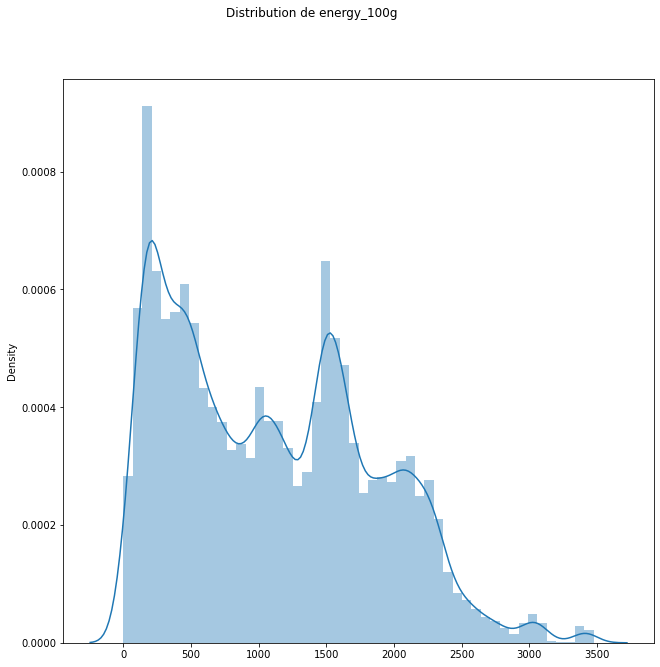

In [96]:
plot(df_clean, "energy_100g")

#### Valeur nutritionelle pour 100g ```nutrition-score-fr_100g```

,nb_unique,nb_manquants,% manquant,minimum,quantile 5%,Q1,mediane,Q3,quantile 95%,maximum,amplitude,IQR,moyenne,écart-type,variance,somme,kurtosis,coefficient de variation
0,53,3844,5.91767,-15.0,-5.0,1.0,9.0,16.0,24.0,40.0,55.0,15.0,8.724138,9.049077,81.885789,533167.0,-0.938873,103.724588


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


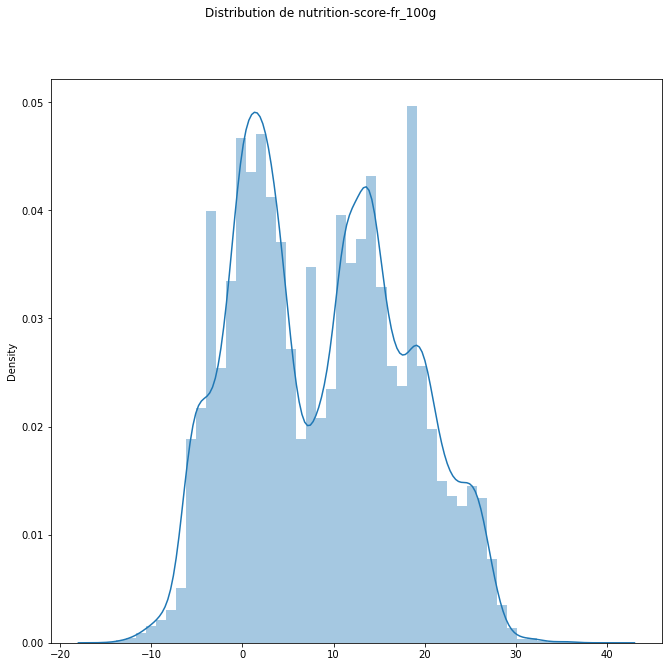

In [97]:
plot(df_clean, "nutrition-score-fr_100g")

Maintenant, comparons la taille de nos données filtrées avec les données d'origine :

In [98]:
print("Avant nettoyage, le dataset contenait {} lignes et {} colonnes".format(df.shape[0], df.shape[1]))
print("Après nettoyage, le dataset contient {} lignes et {} colonnes".format(df_clean.shape[0], df_clean.shape[1]))

Avant nettoyage, le dataset contenait 320772 lignes et 162 colonnes
Après nettoyage, le dataset contient 64958 lignes et 24 colonnes


Sauvegardons notre dataset pour la deuxième partie de cette analyse

In [99]:
df_clean.to_csv("df_cleaned.csv")